# ASTR 403 Poster Project
## 1D gravity simulations (based on Schultz et al. 2013)

### The fiducial simulation

In [1]:
#import numpy as np
#import matplotlib.pyplot as plt
%pylab inline
import wendy as wd
import tqdm

import matplotlib.animation as ani
from IPython.display import HTML
_SAVE_GIFS= False
# rcParams.update({'axes.labelsize': 14.,
#               'font.size': 14.,
#               'legend.fontsize': 17.,
#               'xtick.labelsize':14.,
#               'ytick.labelsize':14.,
#               'text.usetex': _SAVE_GIFS,
#               'figure.figsize': [10,5],
#               'xtick.major.size' : 4,
#               'ytick.major.size' : 4,
#               'xtick.minor.size' : 2,
#               'ytick.minor.size' : 2,
#               'legend.numpoints' : 1,
#               'image.cmap' : 'viridis'})

%config InlineBackend.figure_format = 'retina'
import seaborn as sb
sb.set_context('poster')
sb.set_style('white') 
sb.set_style('ticks')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sim(x, v, m, tf, nt):
    N = len(x)
    dt = tf / nt

    g = wd.nbody(x, v, m, dt, maxcoll=10000000000)

    xt = np.empty((N, nt))
    vt = np.empty((N, nt))
    Pt = np.empty(nt)
    Kt = np.empty(nt)

    E0 = wd.energy(x, v, m)

    for ii in tqdm.trange(nt):
        xt[:, ii] = x
        vt[:, ii] = v
        Kt[ii] = wd.energy(x, v, m, energy_type=wd.EnergyType.KINETIC)
        Pt[ii] = wd.energy(x, v, m, energy_type=wd.EnergyType.POTENTIAL)
        if np.abs((Kt[ii] + Pt[ii]) / E0 - 1) > 0.01:
            raise RuntimeError('Energy diverging')
        x, v = next(g)

    return xt, vt, Kt, Pt

In [3]:
def density_profile(xt, ti):
    ti_ind = int(ti / dt)
    nbins = 500
    bins = np.linspace(0, np.pi/2, nbins)
    
    hist, b = np.histogram(np.abs(xt[:, ti_ind:]), bins=bins)
    bin_centers = (np.roll(b, -1)[0:len(b)-1] + b[0:len(b)-1]) / 2.
    if np.any(hist < 200):
        raise RuntimeWarning('Less than 200 particles in bin')
    densities = hist / np.sum(hist)

    return bin_centers, densities

def density_profile_log(xt, trange, nbins=20):
    bins = np.geomspace(1e-4, pi/2, nbins)
    
    hist, b = np.histogram(np.abs(xt[:, trange]), bins=bins)
    bin_sizes= np.roll(b, -1)[0:len(b)-1] - b[0:len(b)-1]
    bin_centers = (np.roll(b, -1)[0:len(b)-1] + b[0:len(b)-1]) / 2.
    #if np.any(hist < 10):
    #    raise RuntimeWarning('Less than 10 particles in bin')
    densities = hist / bin_sizes / np.sum(hist)

    return bin_centers, densities

In [4]:
def plot_ic(x, v):
    figure(figsize=[5, 5])
    scatter(x, v, c=np.abs(x), s=4, edgecolors='None', cmap='viridis')
    title('Initial conditions')
    xlabel('x')
    ylabel('v')

def plot_energies(t, Kt, Pt):
    figure(figsize=[12, 8])
    subplot(2, 1, 1)
    plot(t, Kt + Pt)
    ylabel('KE + PE')
    xticks([])

    subplot(2, 1, 2)
    plot(t, Kt / Pt)
    ylim([0, 1])
    xlabel('Time')
    ylabel('KE / PE')
    
def plot_density_profile(x, d):
    figure(figsize=[10, 5])
    loglog(x, d, 'o', markersize=2)
    title('Density profile')
    xlabel('x')
    ylabel('Normalized number density')

In [5]:
def plot_virialized(xt, vt, ti, tf, dt):
    figsize(15, 5)
    tm = (ti + tf) / 2
    ind1 = int(ti / dt)
    ind2 = int(tm / dt)
    ind3 = int(tf / dt) - 1
    
    subplot(1,3,1)
    scatter(xt[:,ind1], vt[:,ind1], c=np.fabs(x),s=3.,edgecolors='None', cmap='viridis')
    xlim(-3.49,3.49)
    ylim(-2.49,2.49)
    ylabel('v')
    xlabel('x')
    annotate(r'$t={:.2f}$'.format(ti),(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)

    subplot(1,3,2)
    scatter(xt[:, ind2],vt[:,ind2],c=numpy.fabs(x),s=3.,edgecolors='None', cmap='viridis')
    xlim(-3.49,3.49)
    ylim(-2.49,2.49)
    xlabel('x')
    annotate(r'$t={:.2f}$'.format(tm),(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)

    subplot(1,3,3)
    scatter(xt[:, ind3],vt[:,ind3],c=numpy.fabs(x),s=3.,edgecolors='None', cmap='viridis')
    xlim(-3.49,3.49)
    ylim(-2.49,2.49)
    xlabel('x')
    annotate(r'$t={:.2f}$'.format(tf),(0.95,0.95),xycoords='axes fraction',
             horizontalalignment='right',verticalalignment='top',size=18.)
    tight_layout()

In [6]:
# def init_anim_frame():
#     line1= plot([],[])
#     xlabel(r'$x$')
#     ylabel(r'$v$')
#     xlim(-3.49,3.49)
#     ylim(-2.49,2.49)
#     return (line1[0],)

# figsize(6,4)
# fig, ax= subplots()
# line= ax.scatter(x,v,c=numpy.fabs(x),s=5.,edgecolors='None')
# txt= ax.annotate(r'$t=%.0f$' % (0.),
#                  (0.95,0.95),xycoords='axes fraction',
#                  horizontalalignment='right',verticalalignment='top',size=18.)
# subsamp= 4

# def animate(ii):
#     line.set_offsets(numpy.array([xt[:,ii*subsamp],vt[:,ii*subsamp]]).T)
#     txt.set_text(r'$t=%.0f$' % (ii*subsamp/20.))
#     return (line,)
# anim = animation.FuncAnimation(fig,animate,init_func=init_anim_frame,
#                                frames=nt//subsamp,interval=40,blit=True,repeat=True)

# if _SAVE_GIFS:
#     anim.save('schulz_sinx.gif',writer='imagemagick',dpi=80)
# # The following is necessary to just get the movie, and not an additional initial frame
# plt.close()
# out= HTML(anim.to_html5_video())
# plt.close()
# out

In [28]:
N = 500
v0 = 0.001
tf = 500
nt = 99999
t = linspace(0, tf, nt)
dt = tf / nt

m = np.ones(N) / N
x = np.linspace(-np.pi/2, np.pi/2, N)

In [29]:
v = -v0 * np.sin(x) + v0*np.random.normal(size=N)*1e-6

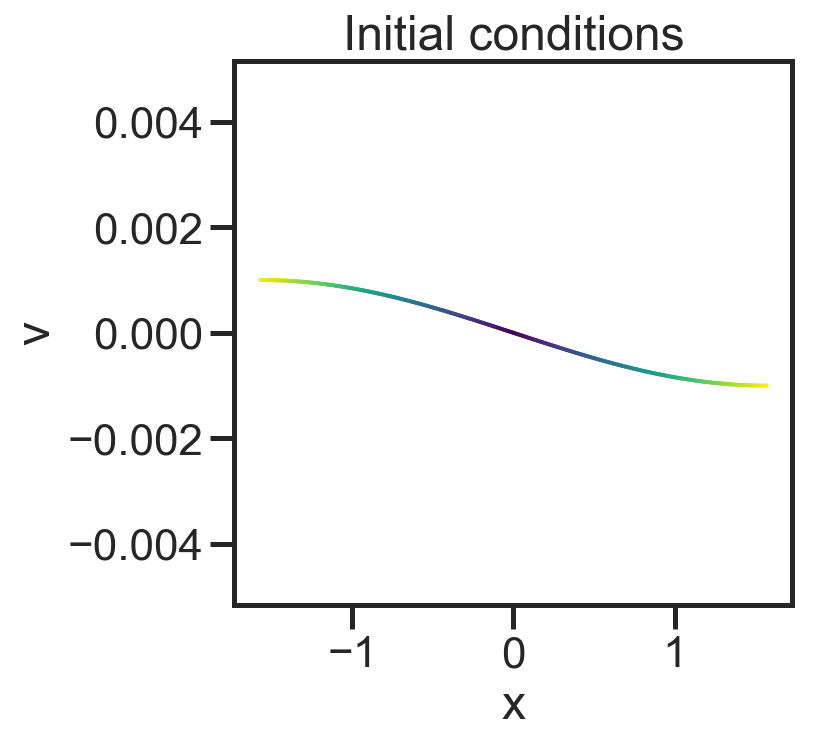

In [30]:
plot_ic(x, v)

In [31]:
xt, vt, Kt, Pt = sim(x, v, m, tf, nt)

100%|██████████| 99999/99999 [01:04<00:00, 1551.75it/s]


In [11]:
np.save('./data/xt', xt)
np.save('./data/vt', vt)
np.save('./data/Kt', Kt)
np.save('./data/Pt', Pt)

In [12]:
xt=np.load('./data/xt.npy')

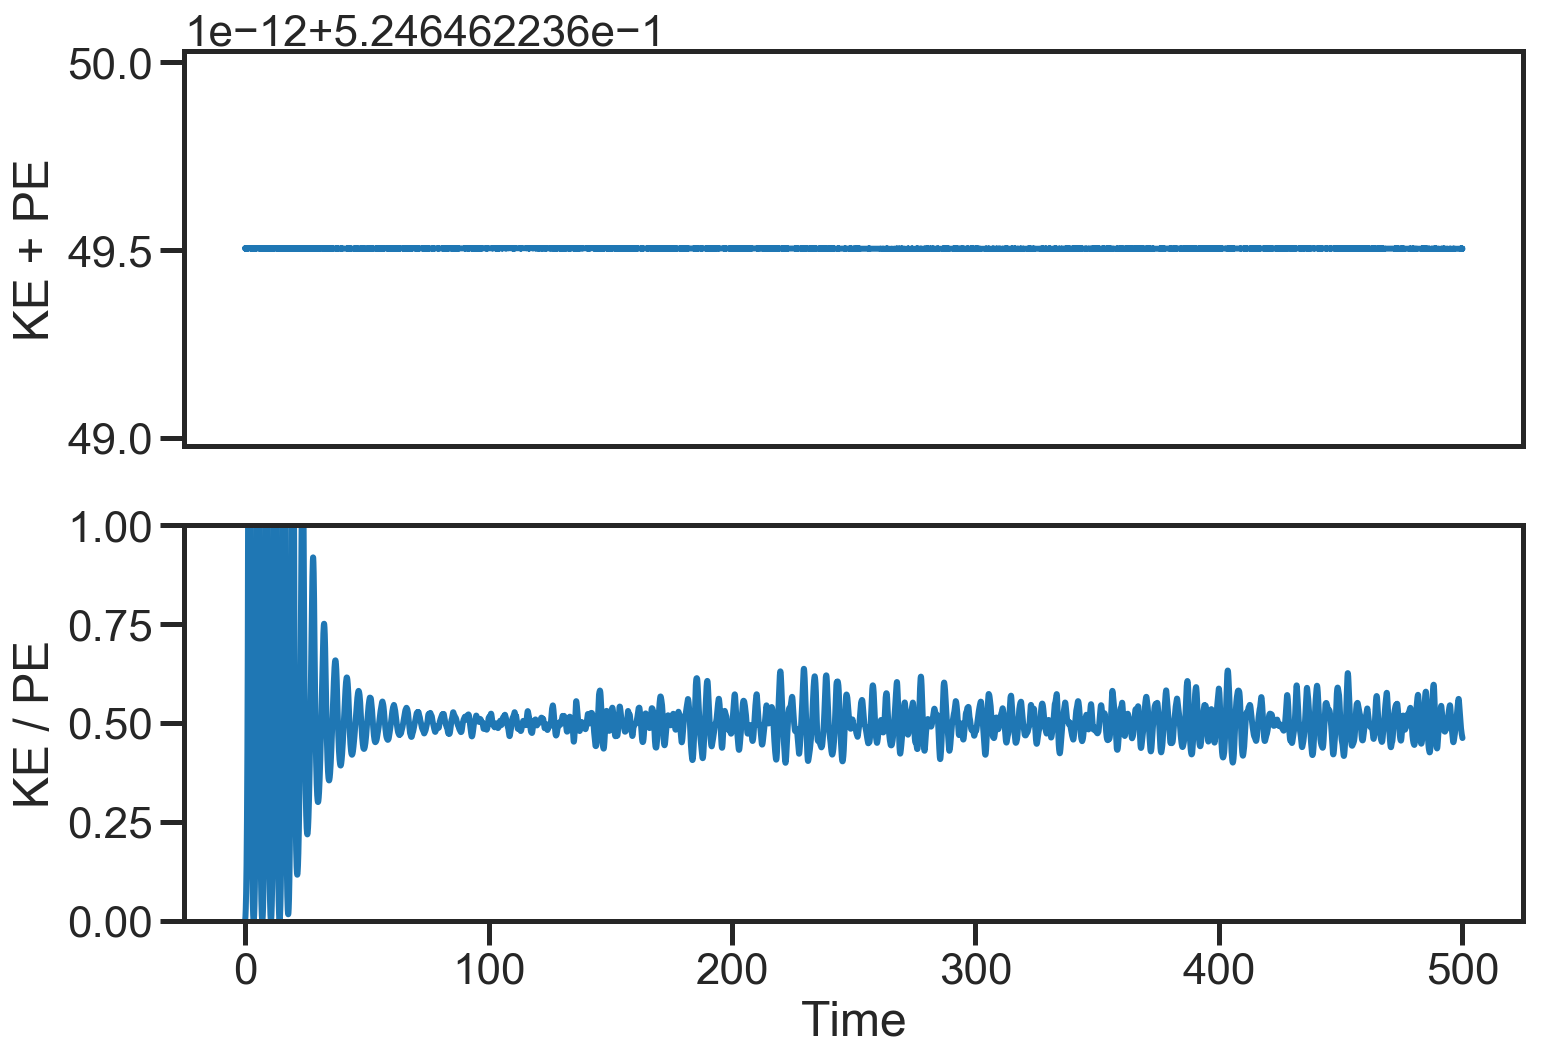

In [32]:
plot_energies(t, Kt, Pt)

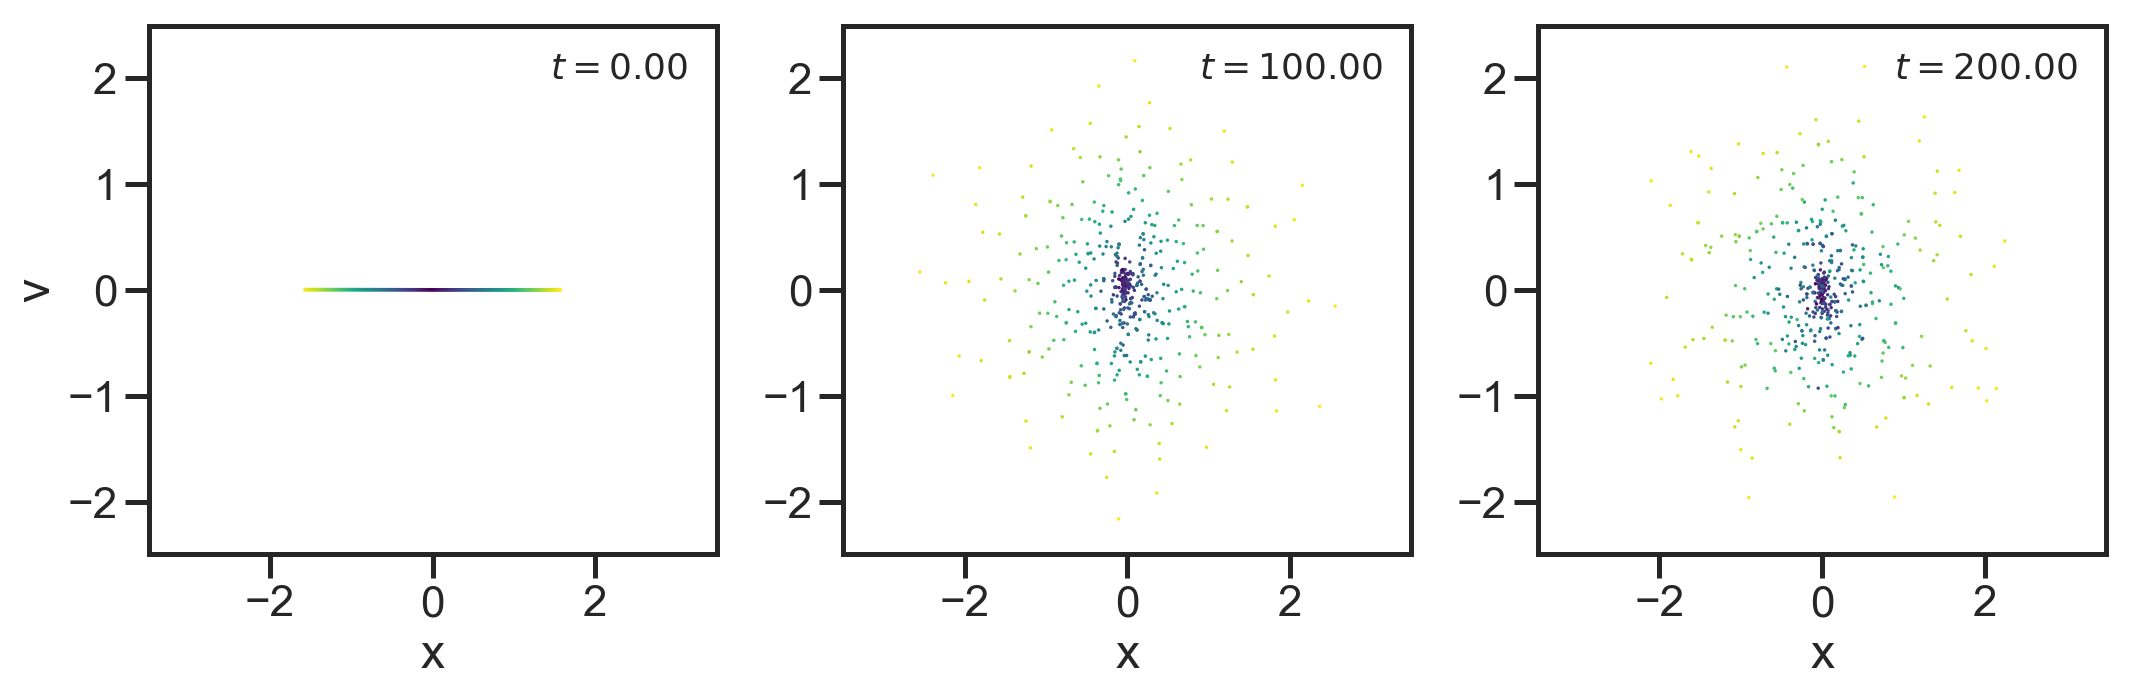

In [33]:
plot_virialized(xt, vt, 0, 200, dt)

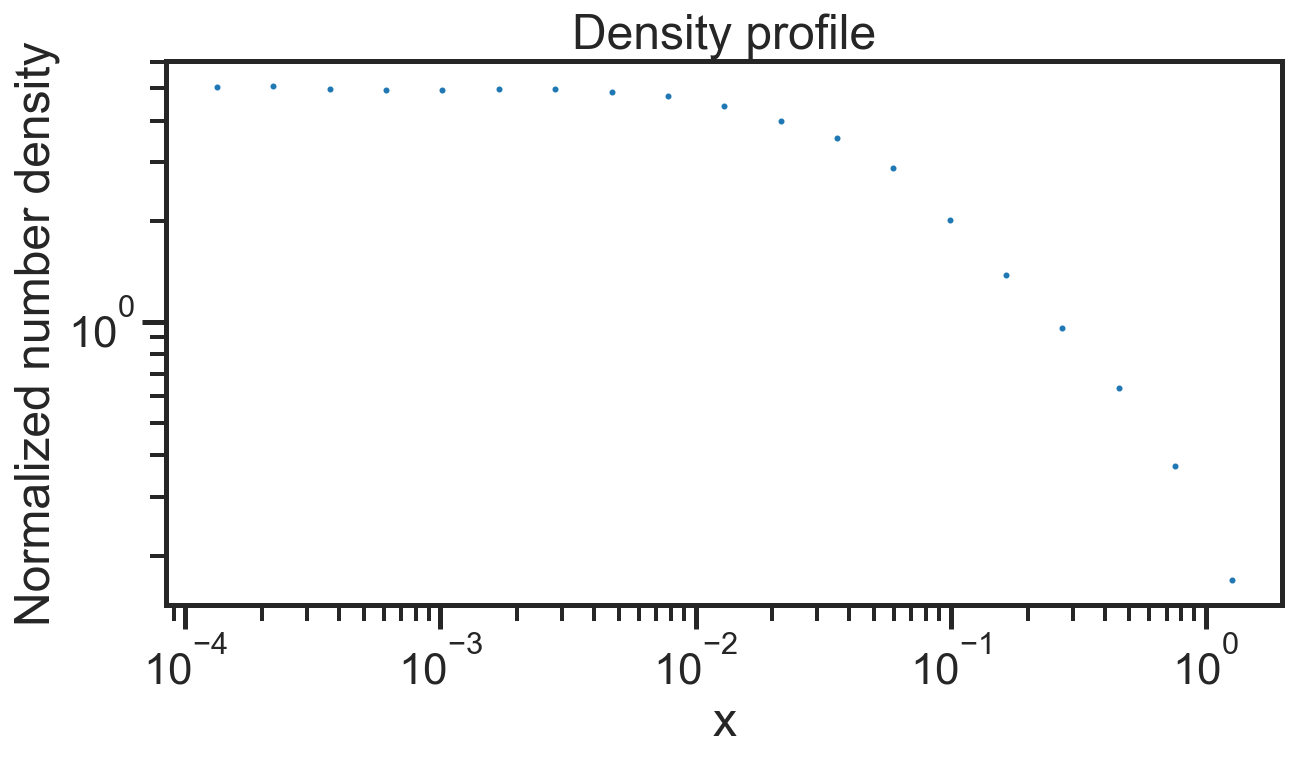

In [35]:
bin_centers, densities = density_profile_log(xt, np.arange(3000, nt))
plot_density_profile(bin_centers, densities)

### Frequency of initial velocity distribution

### 1 wavelength

In [16]:
n_wavelengths = 1
w = 2 * n_wavelengths
v1 = -v0 * np.sin(w*x) + v0*np.random.normal(size=N)*1e-6

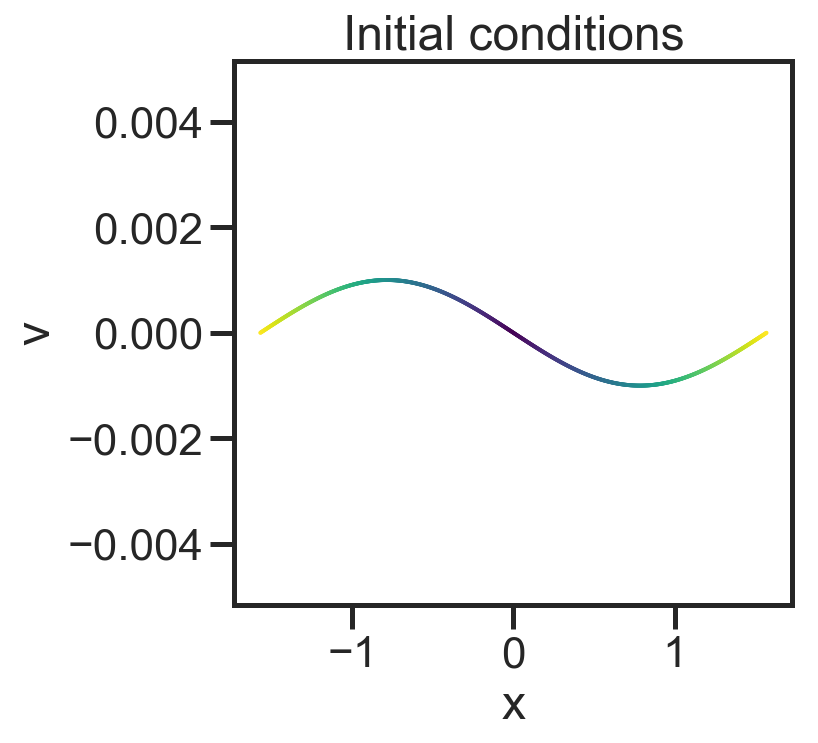

In [17]:
plot_ic(x, v1)

In [18]:
xt1, vt1, Kt1, Pt1 = sim(x, v1, m, tf, nt)

100%|██████████| 10000/10000 [45:03<00:00,  3.70it/s]    


In [19]:
np.save('./data/xt1', xt1)
np.save('./data/vt1', vt1)
np.save('./data/Kt1', Kt1)
np.save('./data/Pt1', Pt1)

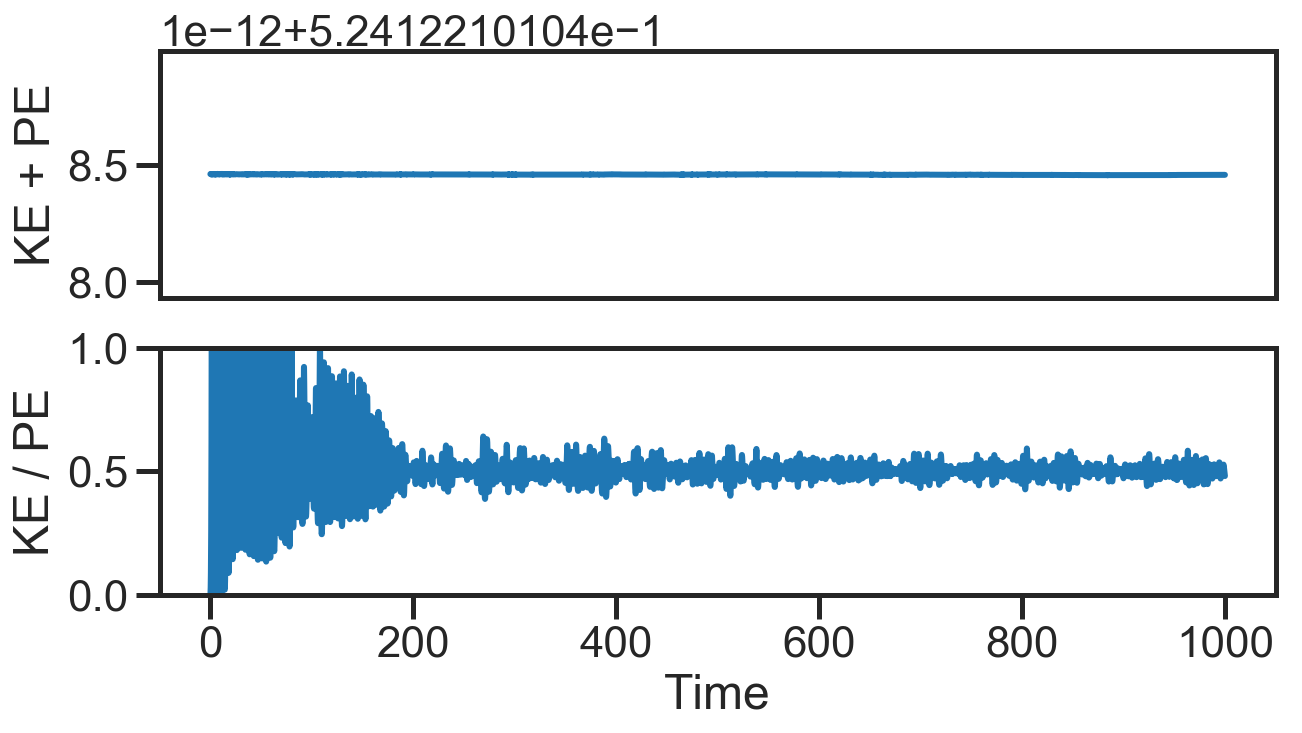

In [20]:
plot_energies(t, Kt1, Pt1)

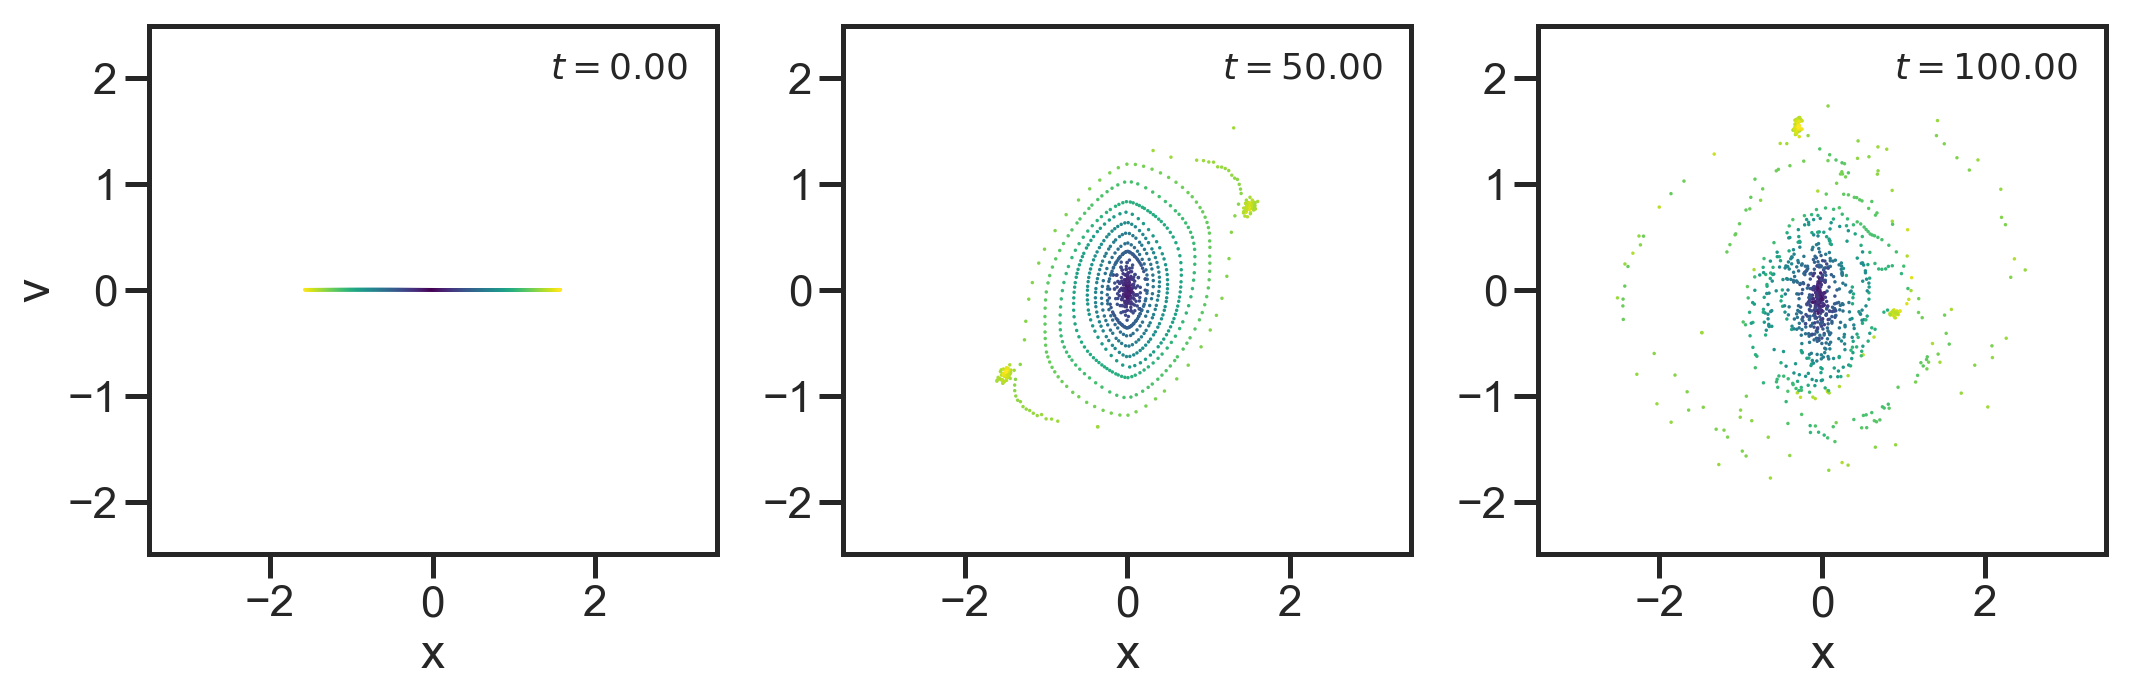

In [179]:
plot_virialized(xt1, vt1, 0, 100, dt)

In [249]:
bin_centers1, densities1 = density_profile_log(xt1, np.arange(9000, nt))
plot_density_profile(bin_centers1, densities1)

RuntimeWarning: Less than 10 particles in bin

### 5 wavelengths

In [23]:
n_wavelengths = 5
w = 2 * n_wavelengths
v5 = -v0 * np.sin(w*x) + v0*np.random.normal(size=N)*1e-6

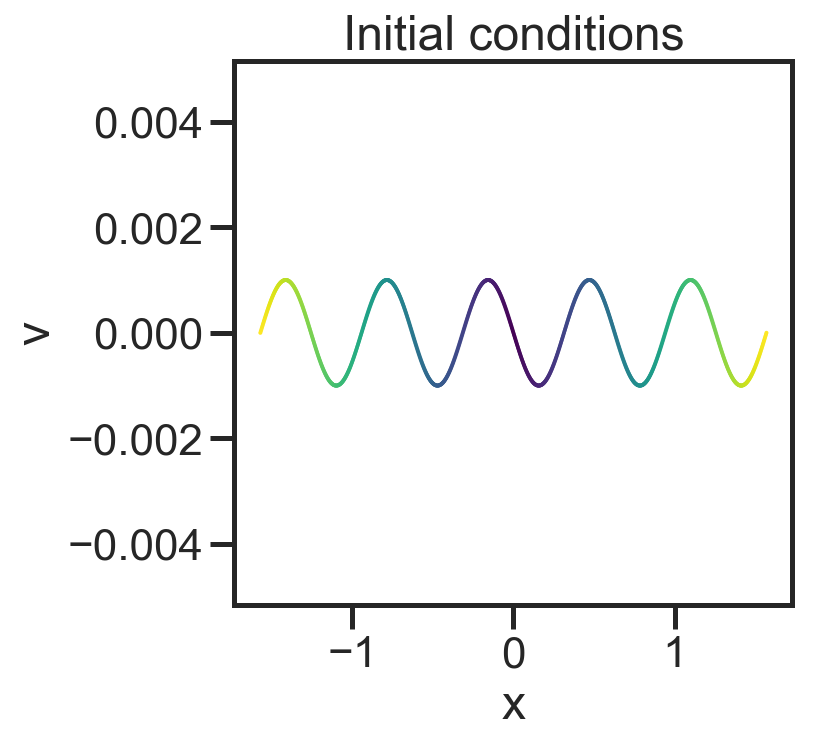

In [24]:
plot_ic(x, v5)

In [25]:
xt5, vt5, Kt5, Pt5 = sim(x, v5, m, tf, nt)

100%|██████████| 10000/10000 [03:46<00:00, 44.16it/s]


In [26]:
np.save('./data/xt5', xt5)
np.save('./data/vt5', vt5)
np.save('./data/Kt5', Kt5)
np.save('./data/Pt5', Pt5)

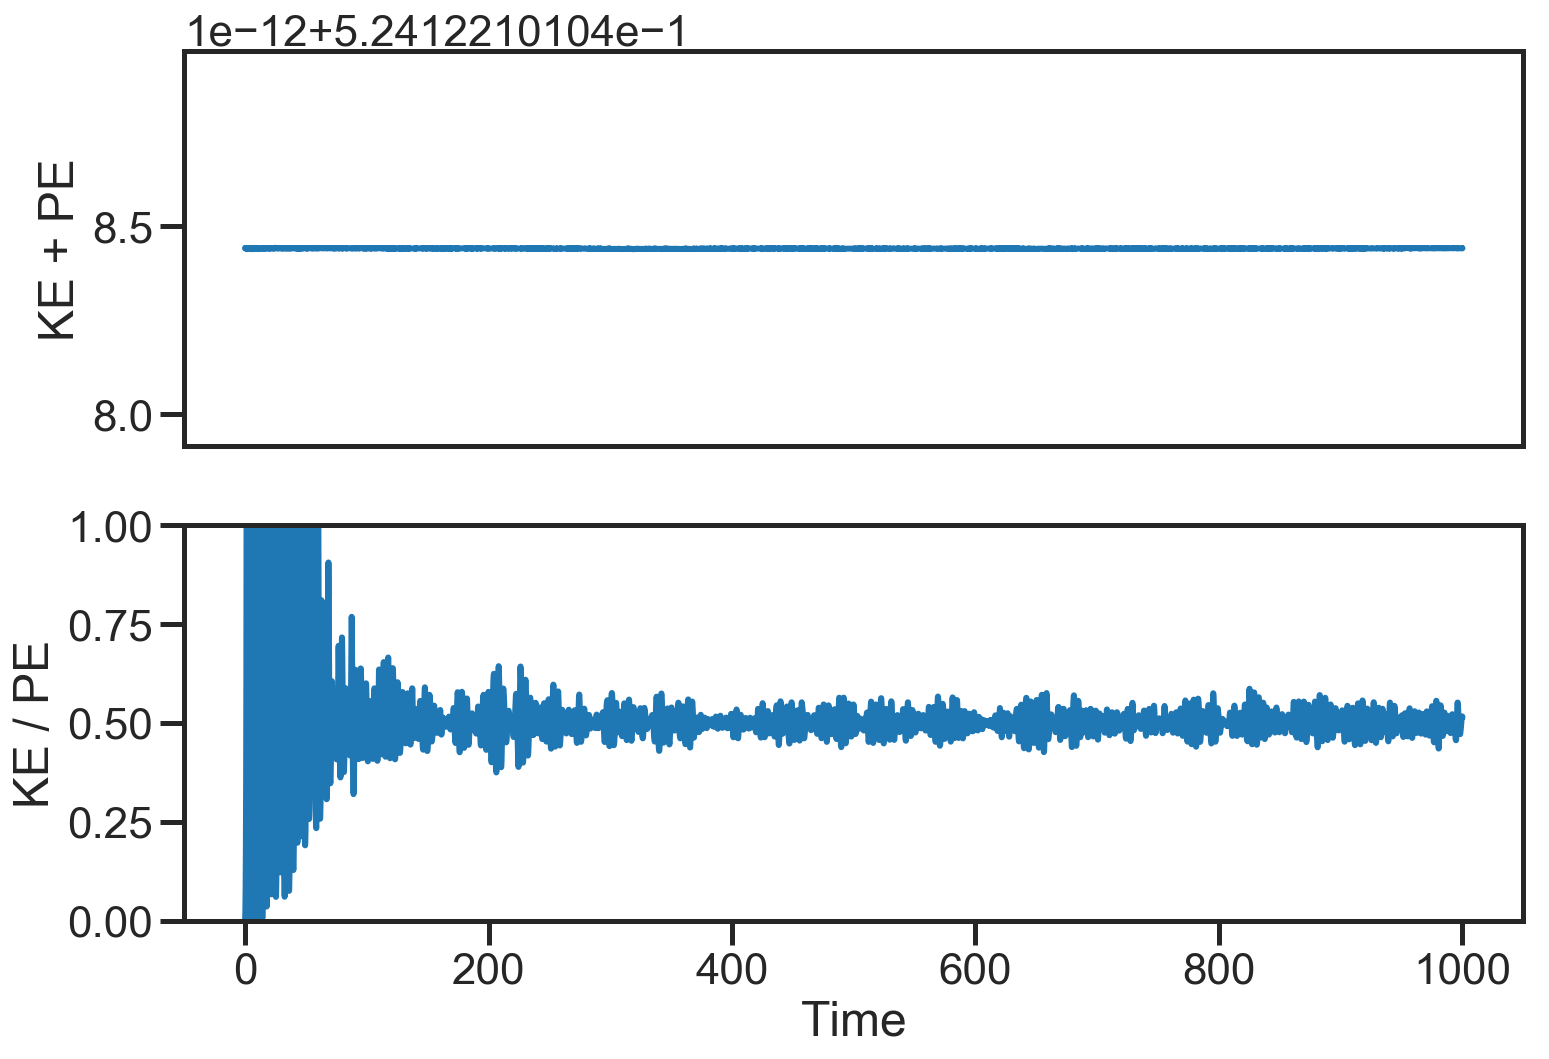

In [246]:
plot_energies(t, Kt5, Pt5)

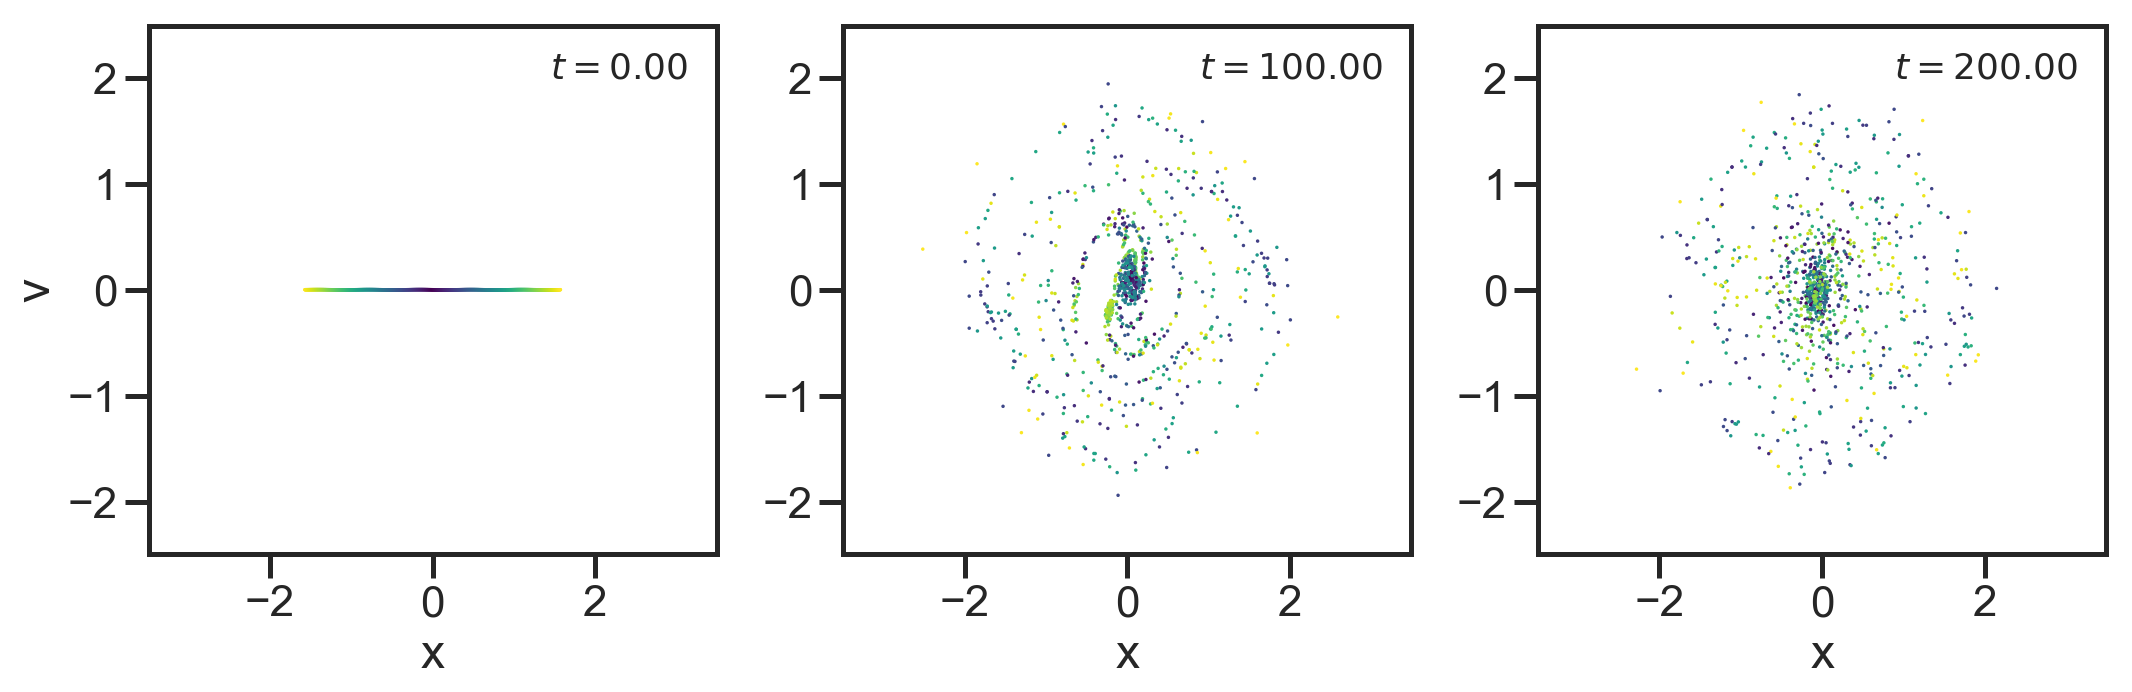

In [114]:
plot_virialized(xt5, vt5, 0, 200, dt)

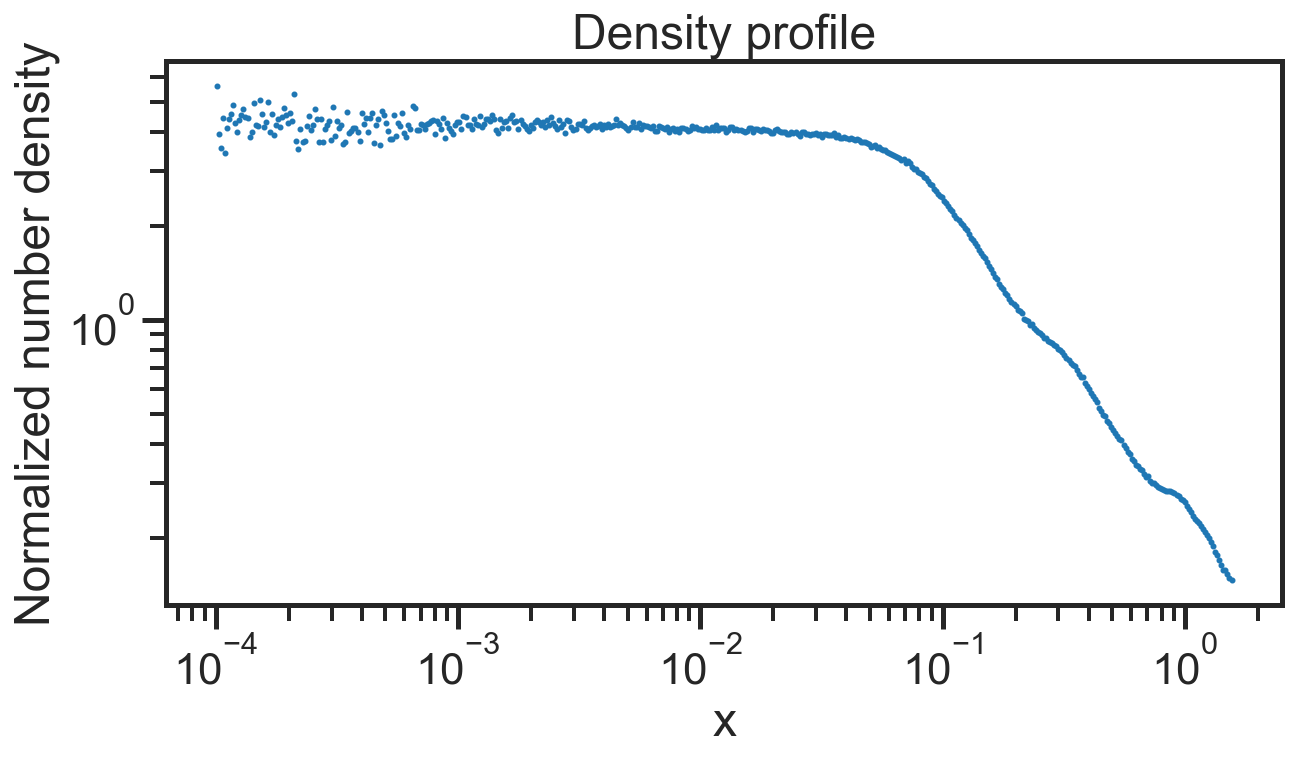

In [240]:
bin_centers5, densities5 = density_profile_log(xt5, arange(3000, nt))
plot_density_profile(bin_centers5, densities5)

### 10 wavelengths

In [30]:
n_wavelengths = 10
w = 2 * n_wavelengths
v10 = -v0 * np.sin(w*x) + v0*np.random.normal(size=N)*1e-6

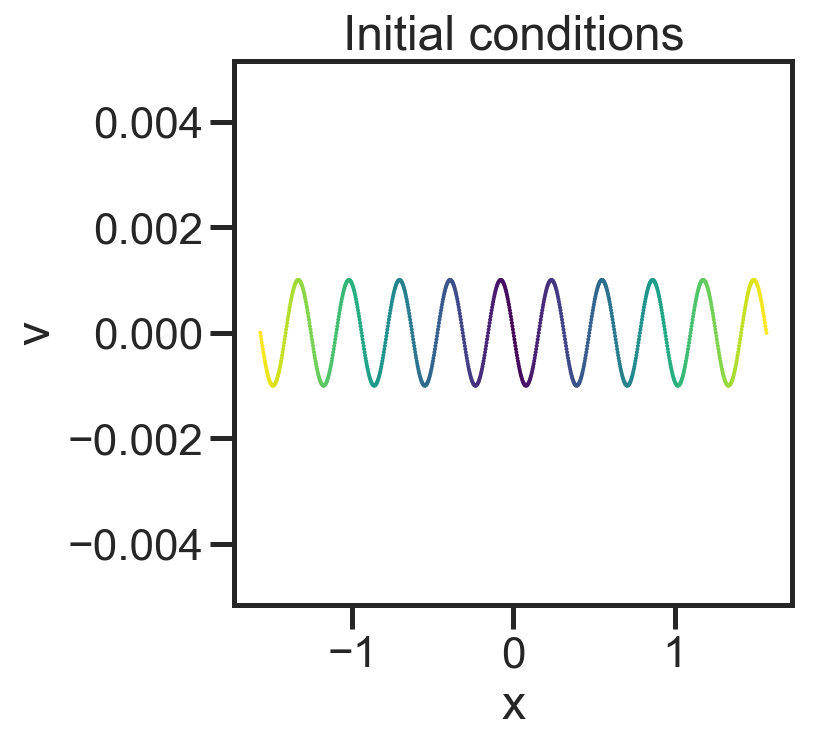

In [31]:
plot_ic(x, v10)

In [32]:
xt10, vt10, Kt10, Pt10 = sim(x, v10, m, tf, nt)

100%|██████████| 10000/10000 [03:33<00:00, 46.92it/s]


In [33]:
np.save('./data/xt10', xt10)
np.save('./data/vt10', vt10)
np.save('./data/Kt10', Kt10)
np.save('./data/Pt10', Pt10)

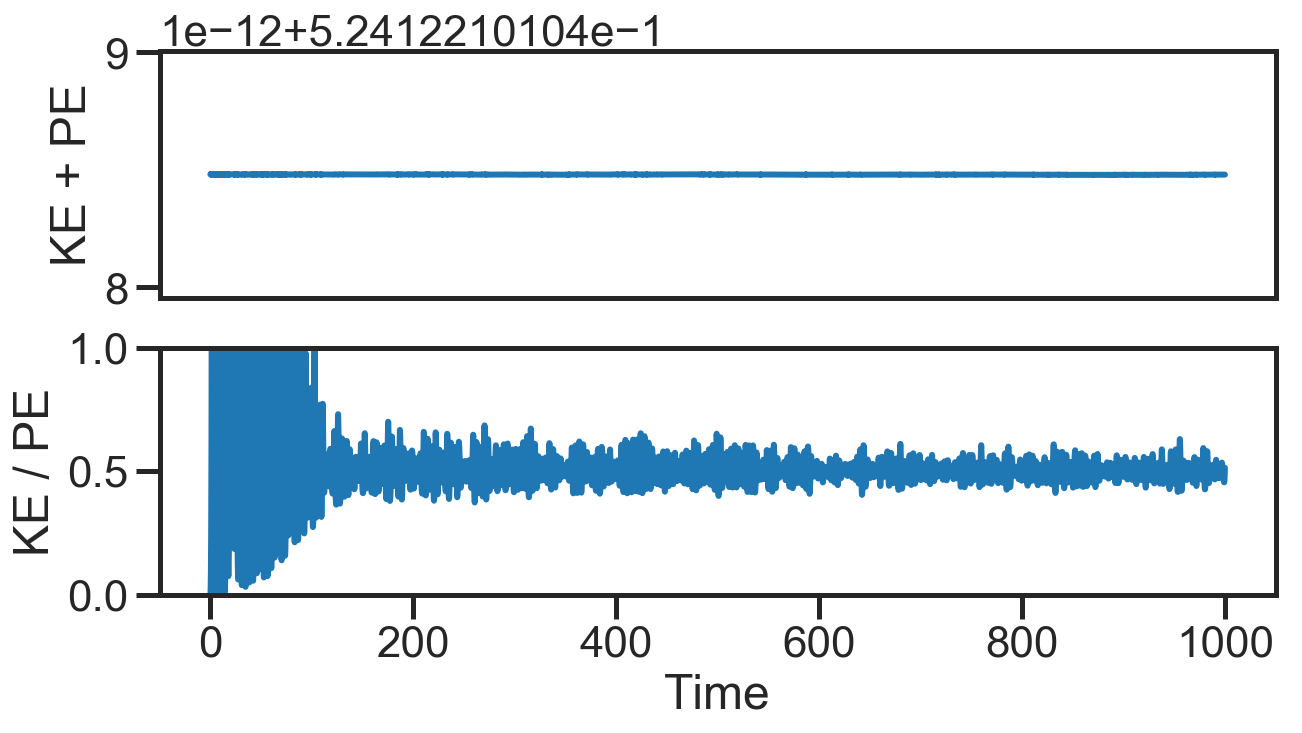

In [34]:
plot_energies(t, Kt10, Pt10)

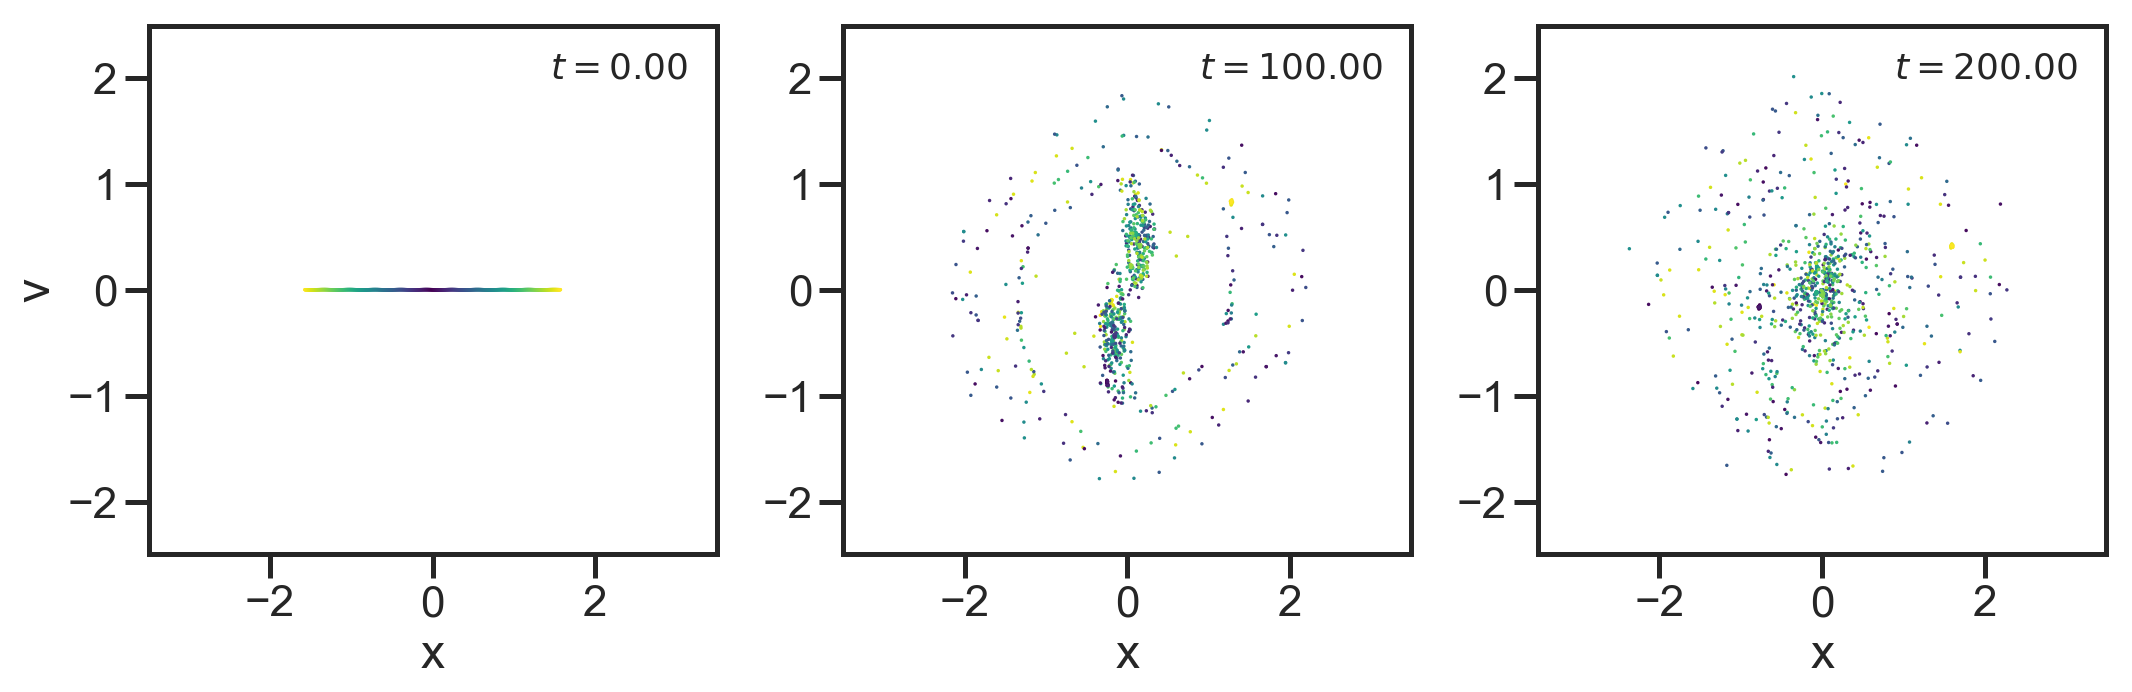

In [115]:
plot_virialized(xt10, vt10, 0, 200, dt)

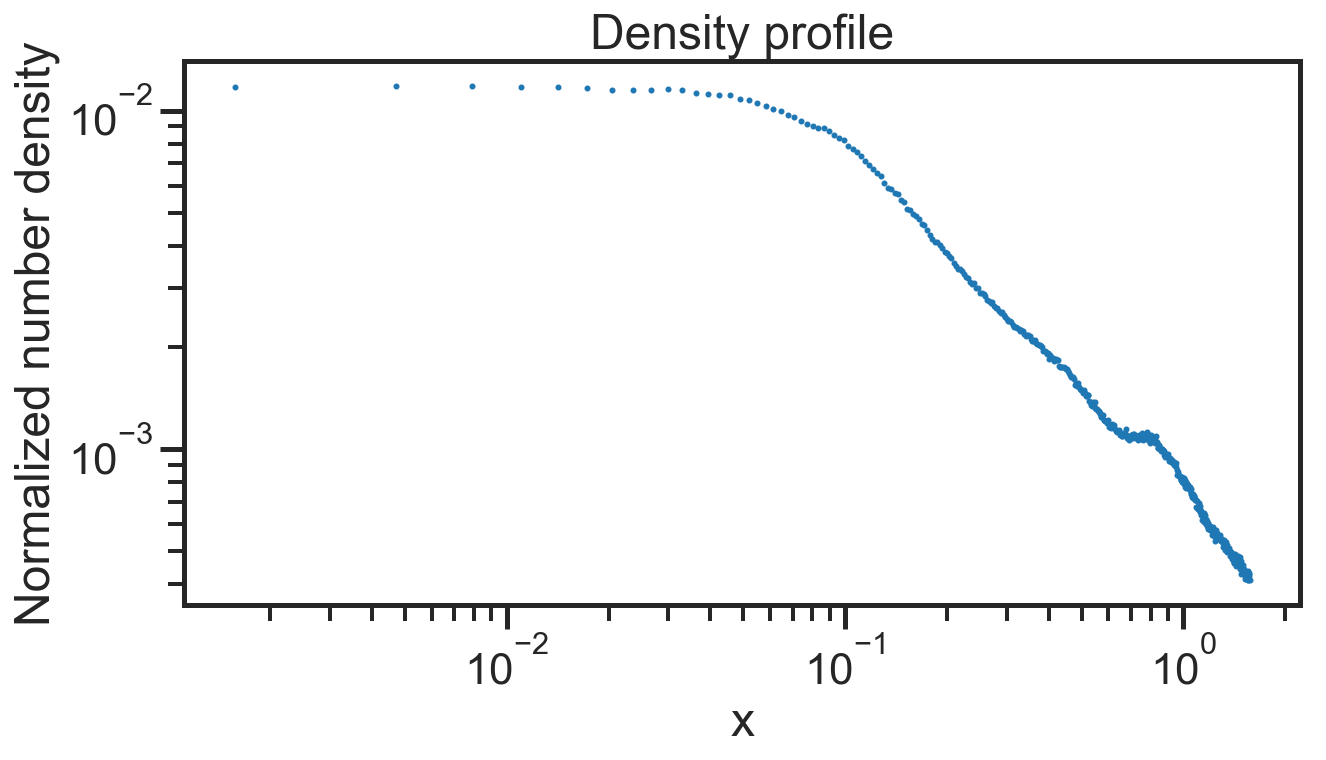

In [220]:
bin_centers10, densities10 = density_profile(xt10, 300)
plot_density_profile(bin_centers10, densities10)

### 30 wavelengths

In [37]:
n_wavelengths = 30
w = 2 * n_wavelengths
v30 = -v0 * np.sin(w*x) + v0*np.random.normal(size=N)*1e-6

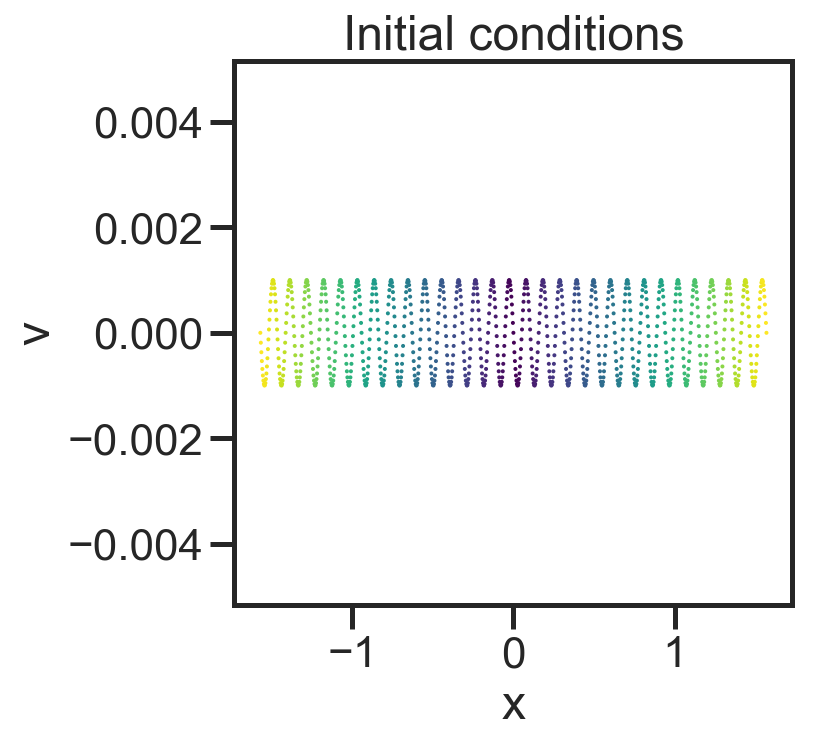

In [38]:
plot_ic(x, v30)

In [39]:
xt30, vt30, Kt30, Pt30 = sim(x, v30, m, tf, nt)

100%|██████████| 10000/10000 [03:32<00:00, 47.00it/s]


In [40]:
np.save('./data/xt30', xt30)
np.save('./data/vt30', vt30)
np.save('./data/Kt30', Kt30)
np.save('./data/Pt30', Pt30)

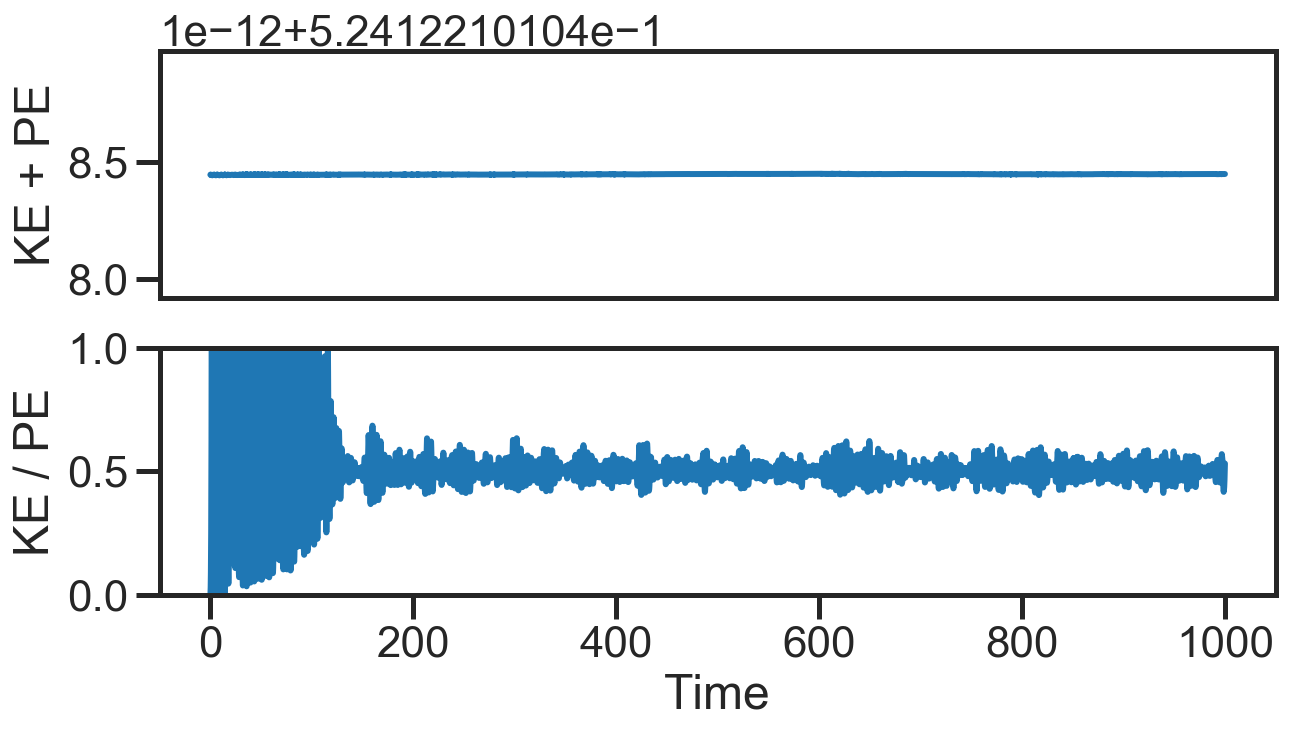

In [41]:
plot_energies(t, Kt30, Pt30)

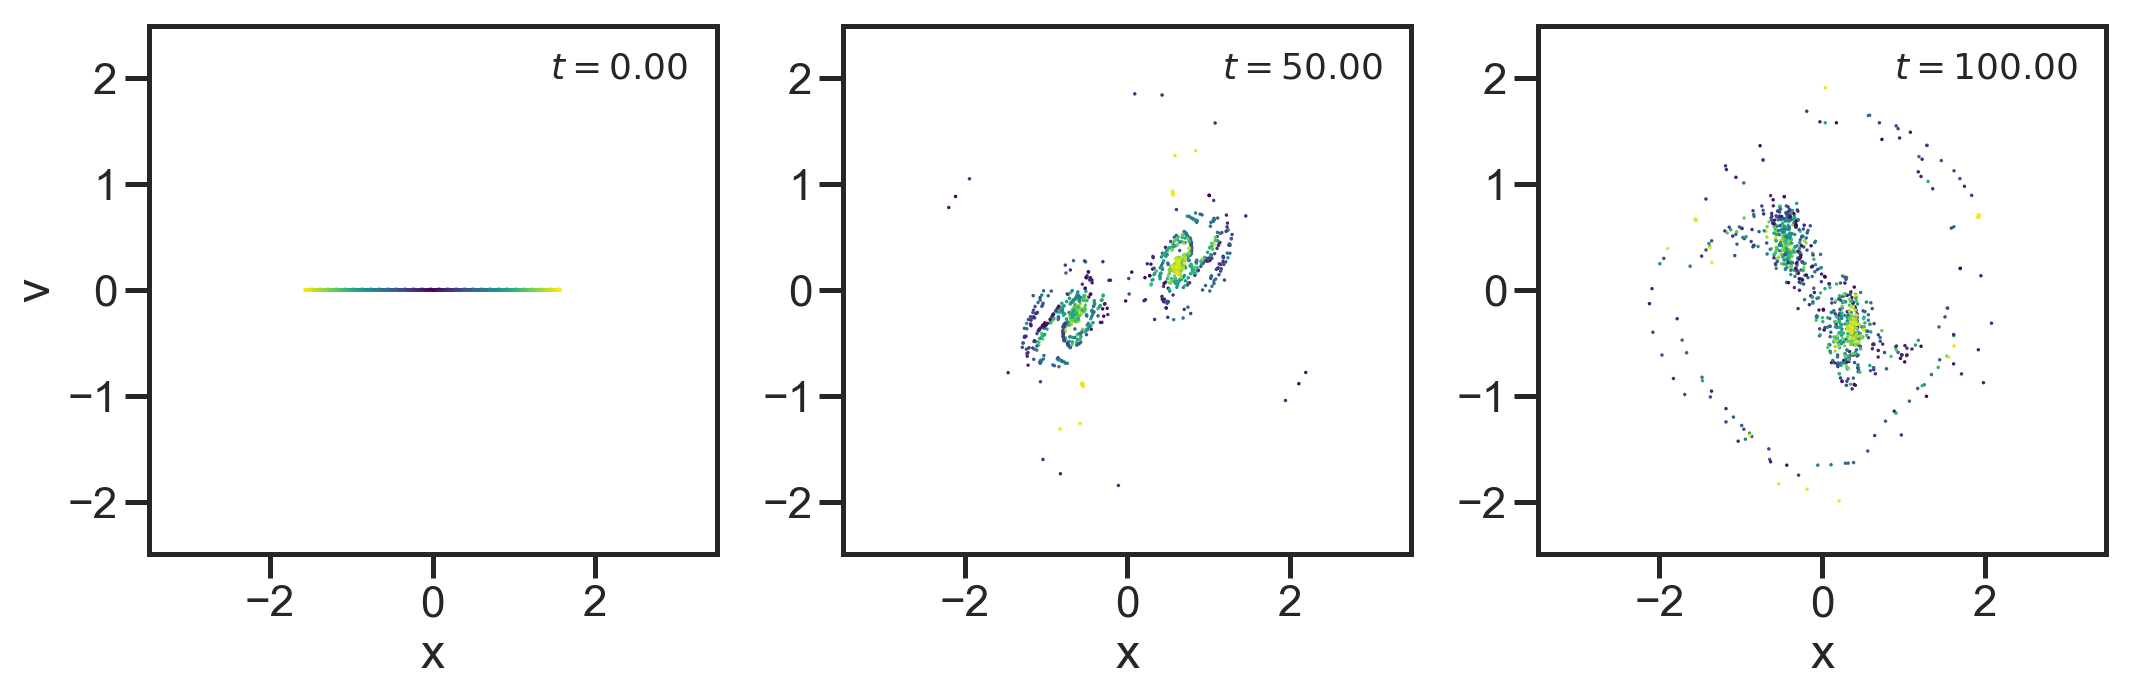

In [183]:
plot_virialized(xt30, vt30, 0, 100, dt)

In [1]:
bin_centers30, densities30 = density_profile_log(xt30, 300)
plot_density_profile(bin_centers30, densities30)

NameError: name 'density_profile_log' is not defined

### 99 wavelengths

In [44]:
n_wavelengths = 99
w = 2 * n_wavelengths
v99 = -v0 * np.sin(w*x) + v0*np.random.normal(size=N)*1e-6

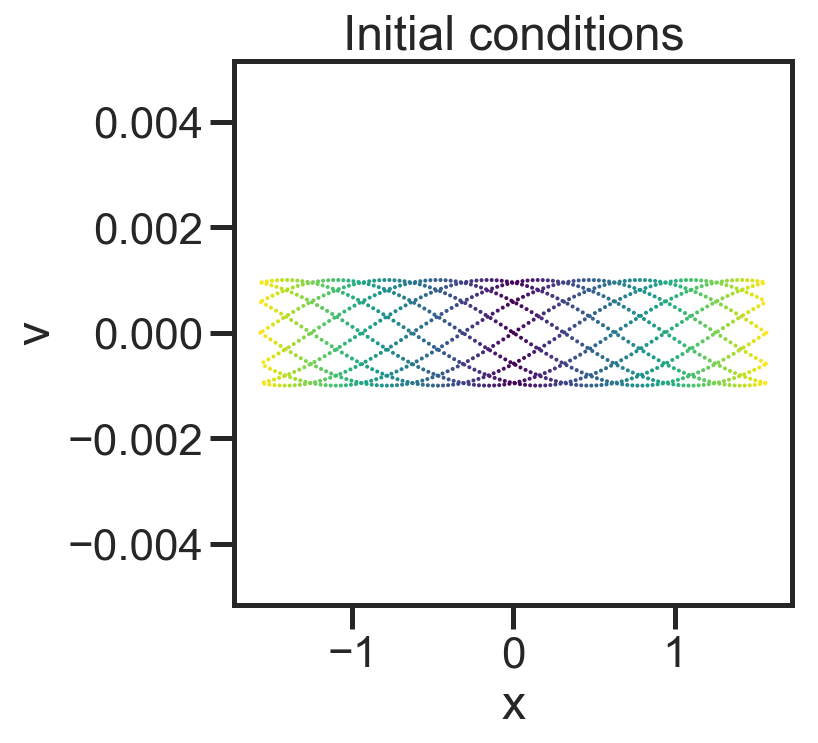

In [45]:
plot_ic(x, v99)

In [46]:
xt99, vt99, Kt99, Pt99 = sim(x, v99, m, tf, nt)

100%|██████████| 10000/10000 [03:30<00:00, 47.41it/s]


In [47]:
np.save('./data/xt99', xt99)
np.save('./data/vt99', vt99)
np.save('./data/Kt99', Kt99)
np.save('./data/Pt99', Pt99)

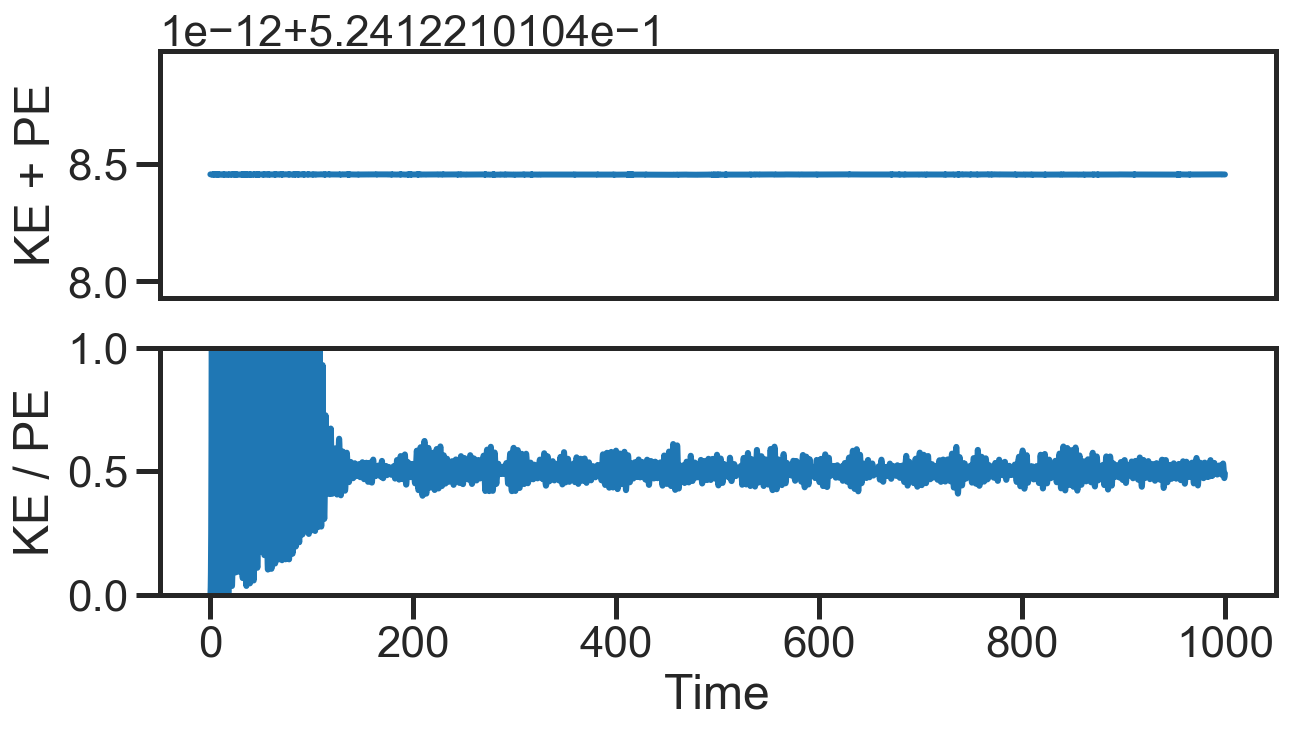

In [48]:
plot_energies(t, Kt99, Pt99)

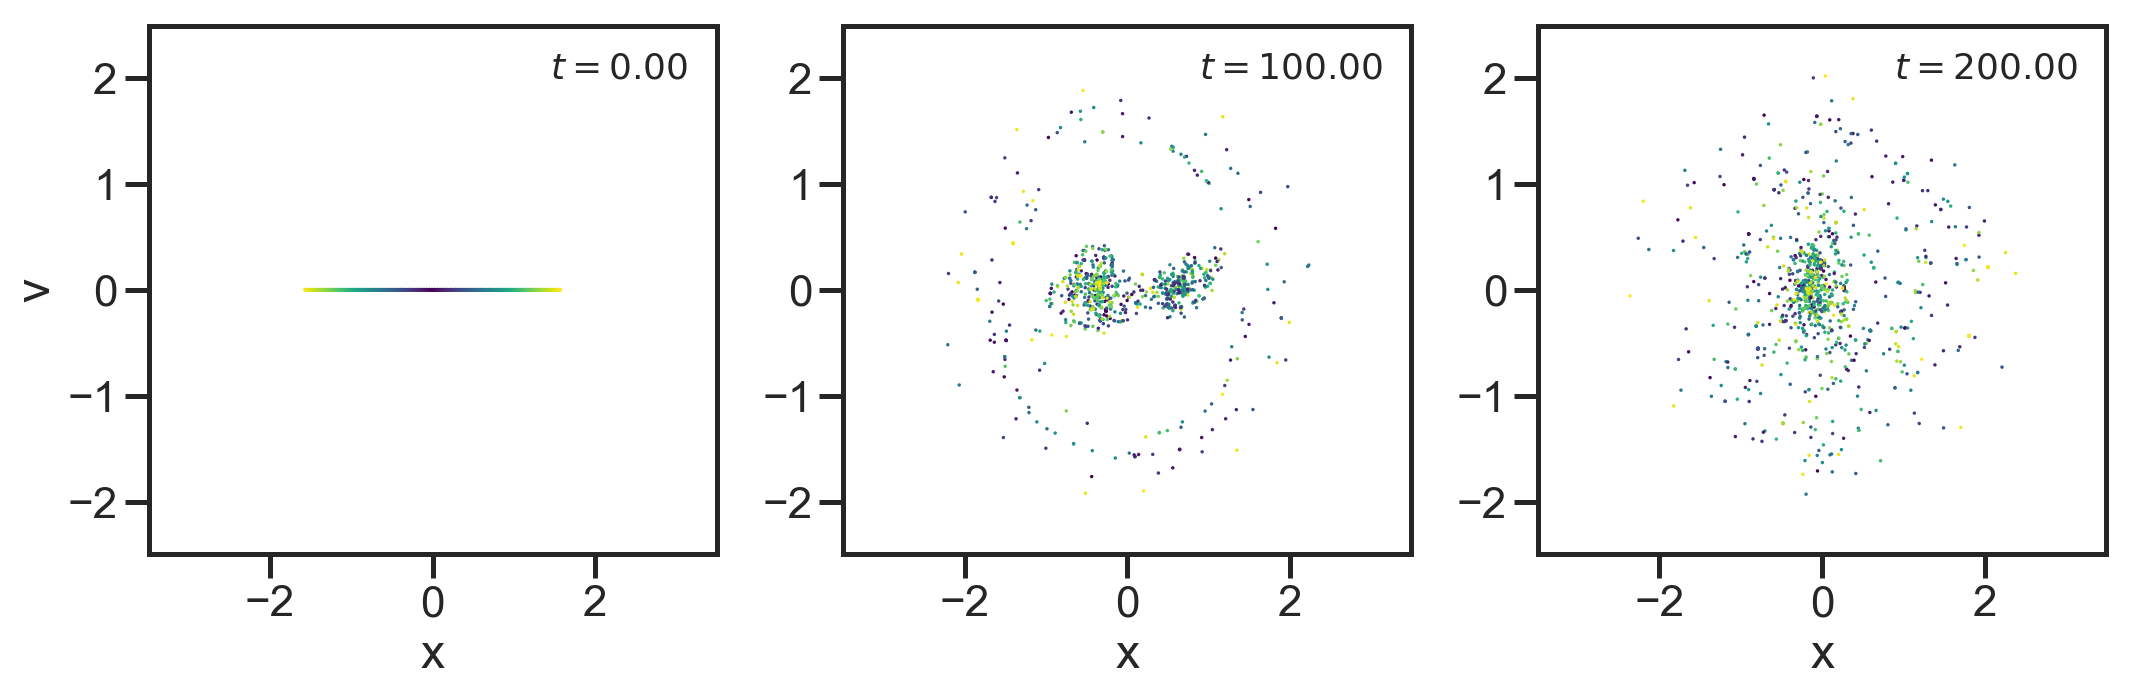

In [117]:
plot_virialized(xt99, vt99, 0, 200, dt)

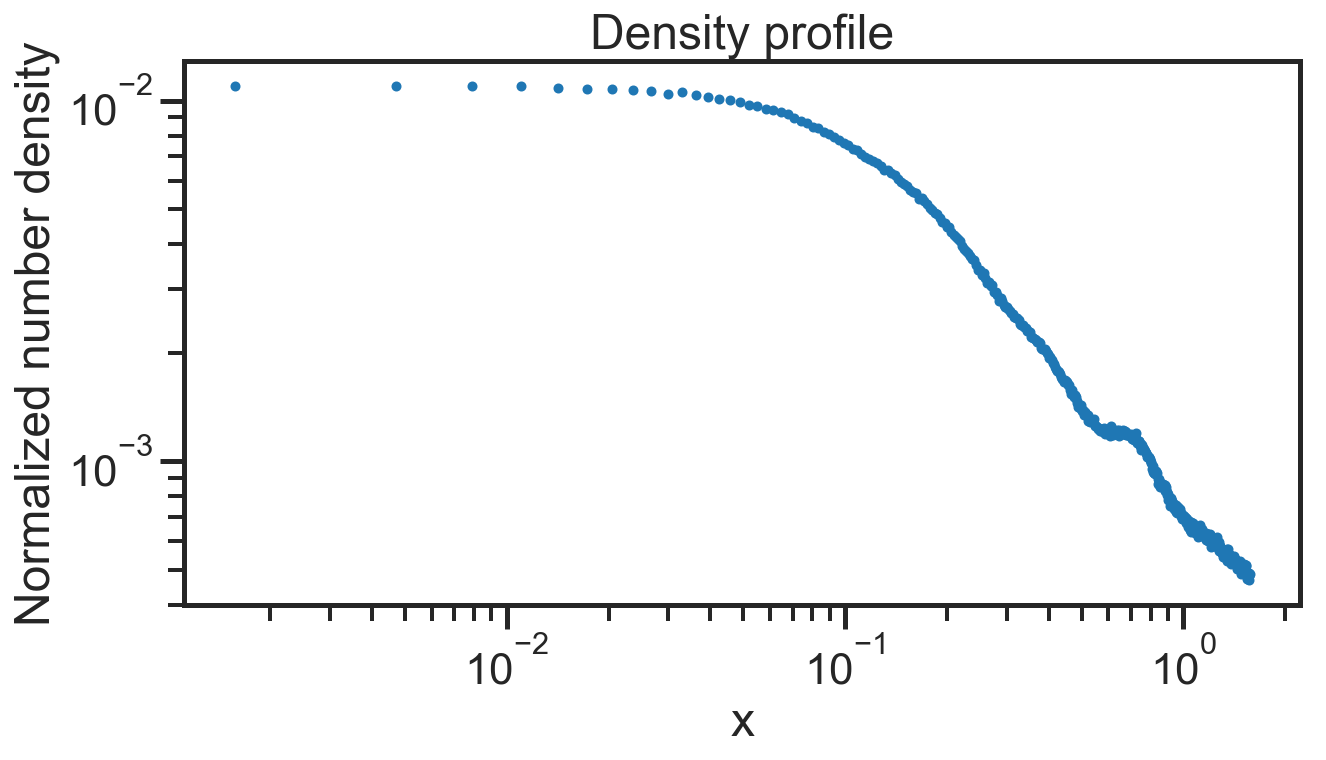

In [102]:
bin_centers99, densities99 = density_profile(xt99, 300)
plot_density_profile(bin_centers99, densities99)

### 480 wavelengths

In [3]:
n_wavelengths = 481
w = 2 * n_wavelengths
v480 = -v0 * np.sin(w*x) + v0*np.random.normal(size=N)*1e-6

NameError: name 'v0' is not defined

In [4]:
plot_ic(x, v480)

NameError: name 'plot_ic' is not defined

In [58]:
xt480, vt480, Kt480, Pt480 = sim(x, v480, m, tf, nt)

100%|██████████| 10000/10000 [03:44<00:00, 44.52it/s]


In [59]:
np.save('./data/xt480', xt480)
np.save('./data/vt480', vt480)
np.save('./data/Kt480', Kt480)
np.save('./data/Pt480', Pt480)

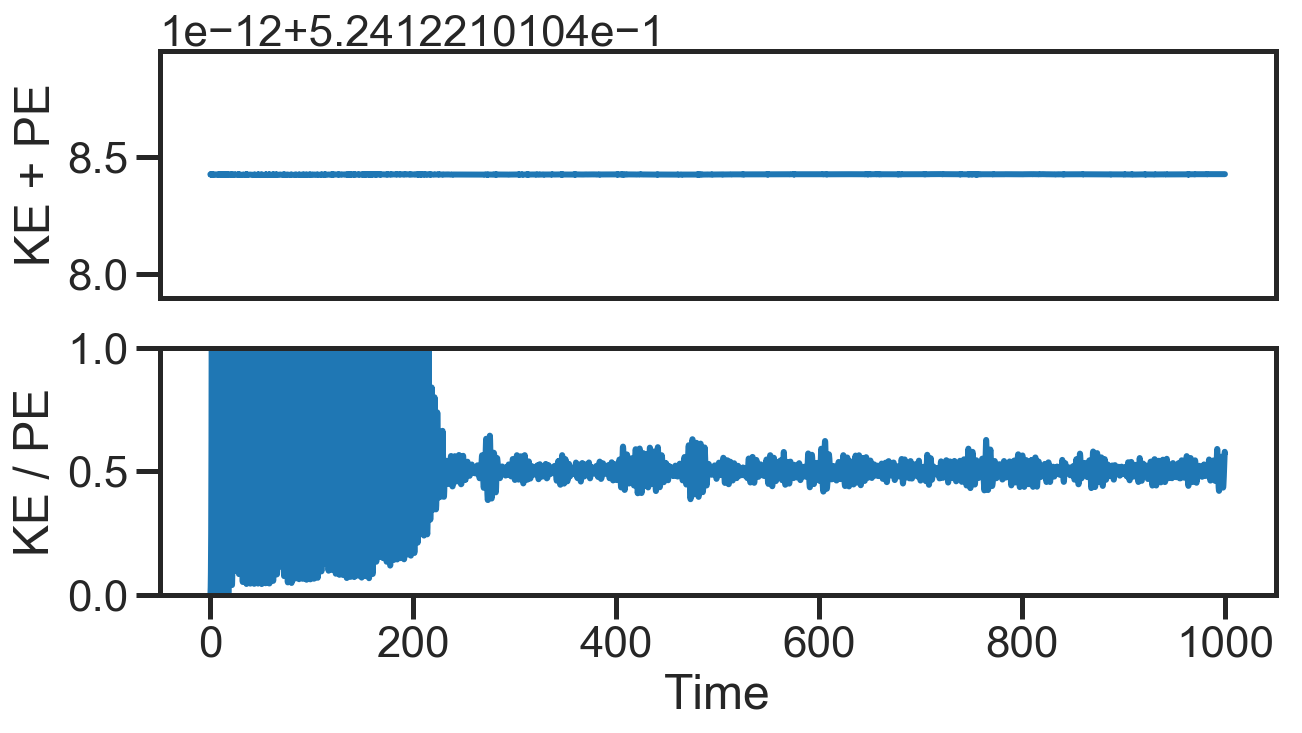

In [60]:
plot_energies(t, Kt480, Pt480)

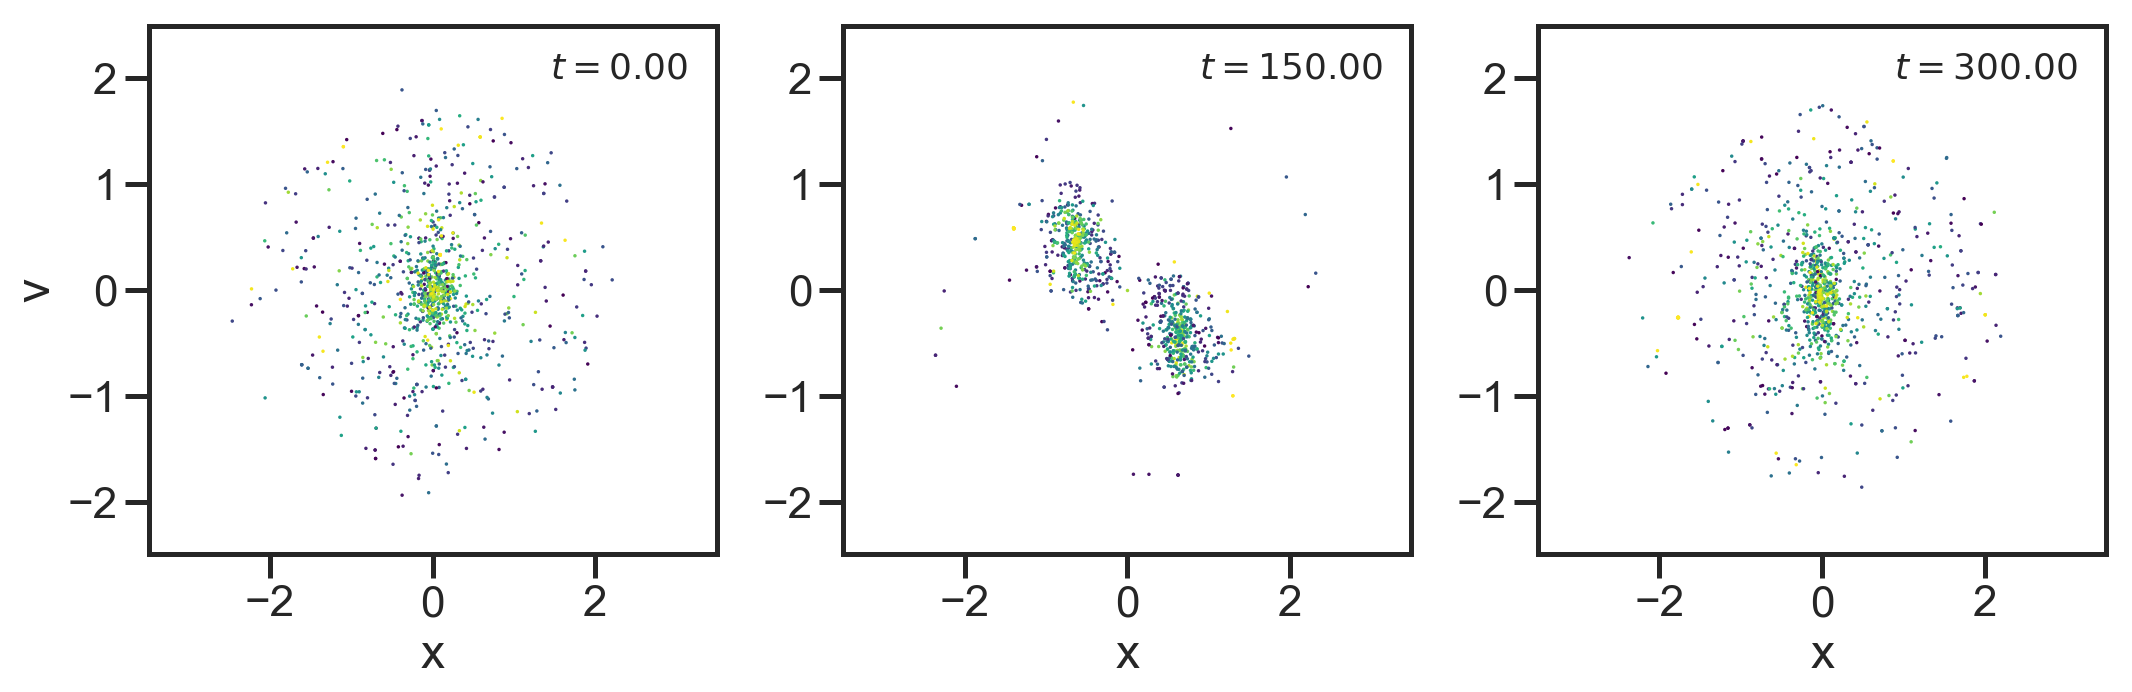

In [107]:
plot_virialized(xt480, vt480, 0, 300, dt)

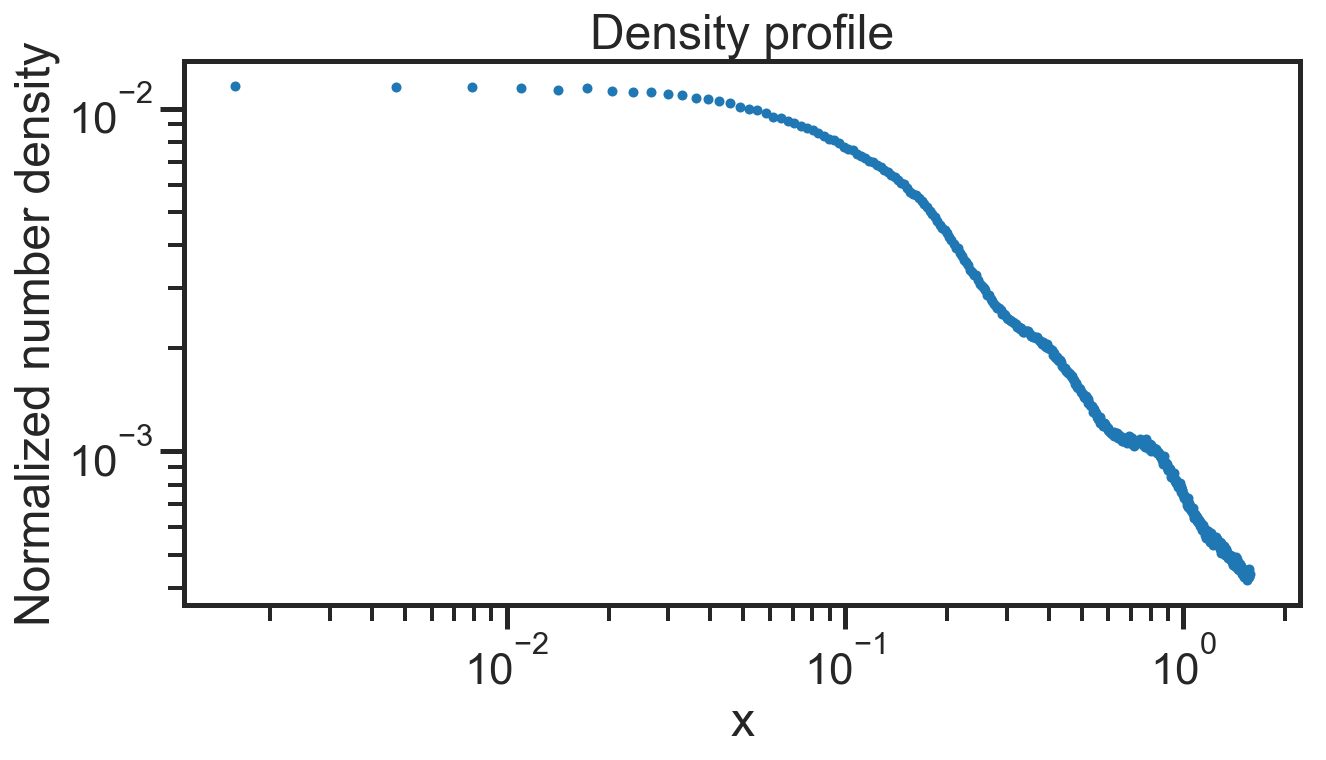

In [103]:
bin_centers480, densities480 = density_profile(xt480, 300)
plot_density_profile(bin_centers480, densities480)

### Gaussian random distribution

In [63]:
vr = v0*np.random.normal(size=N)

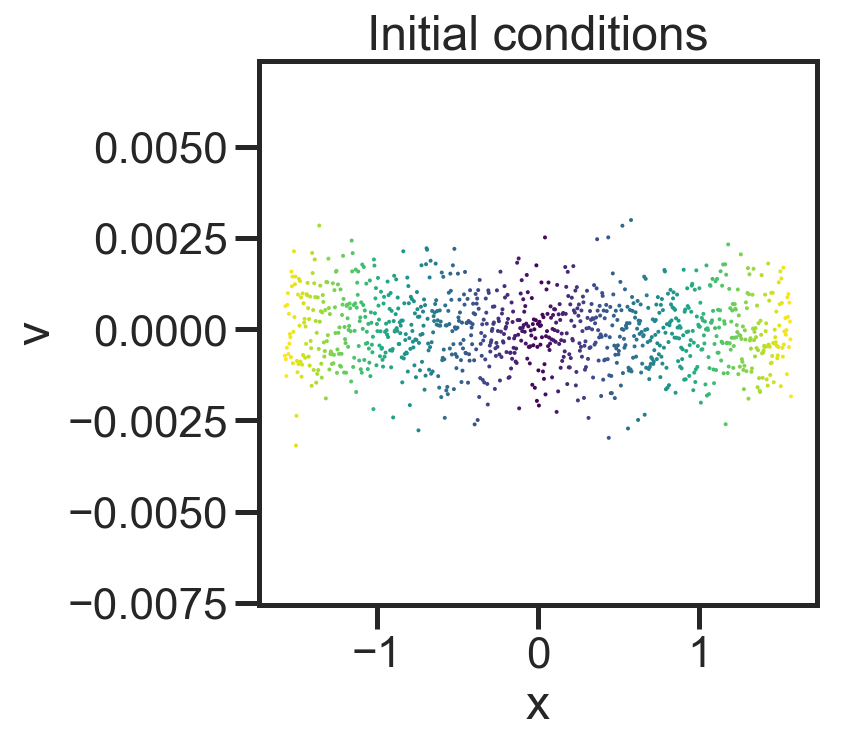

In [64]:
plot_ic(x, vr)

In [65]:
xtr, vtr, Ktr, Ptr = sim(x, vr, m, tf, nt)

100%|██████████| 10000/10000 [03:37<00:00, 45.92it/s]


In [66]:
np.save('./data/xtr', xtr)
np.save('./data/vtr', vtr)
np.save('./data/Ktr', Ktr)
np.save('./data/Ptr', Ptr)

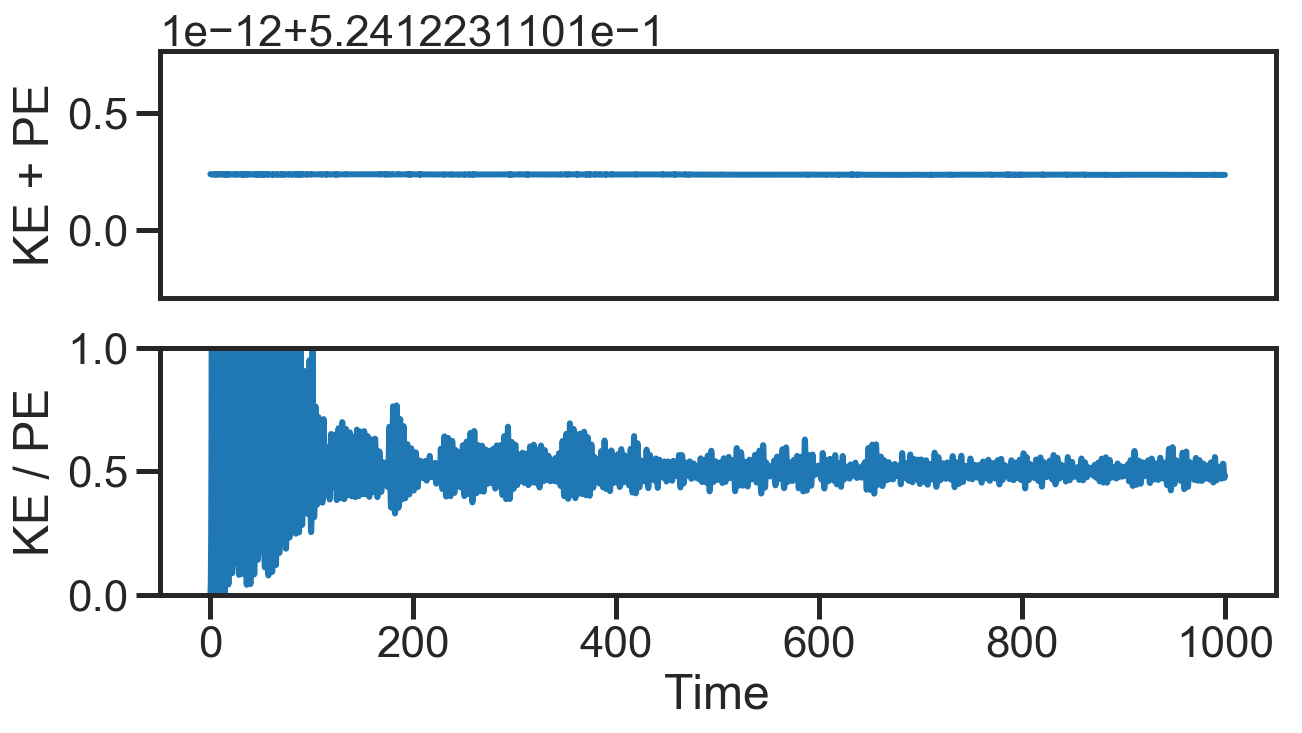

In [67]:
plot_energies(t, Ktr, Ptr)

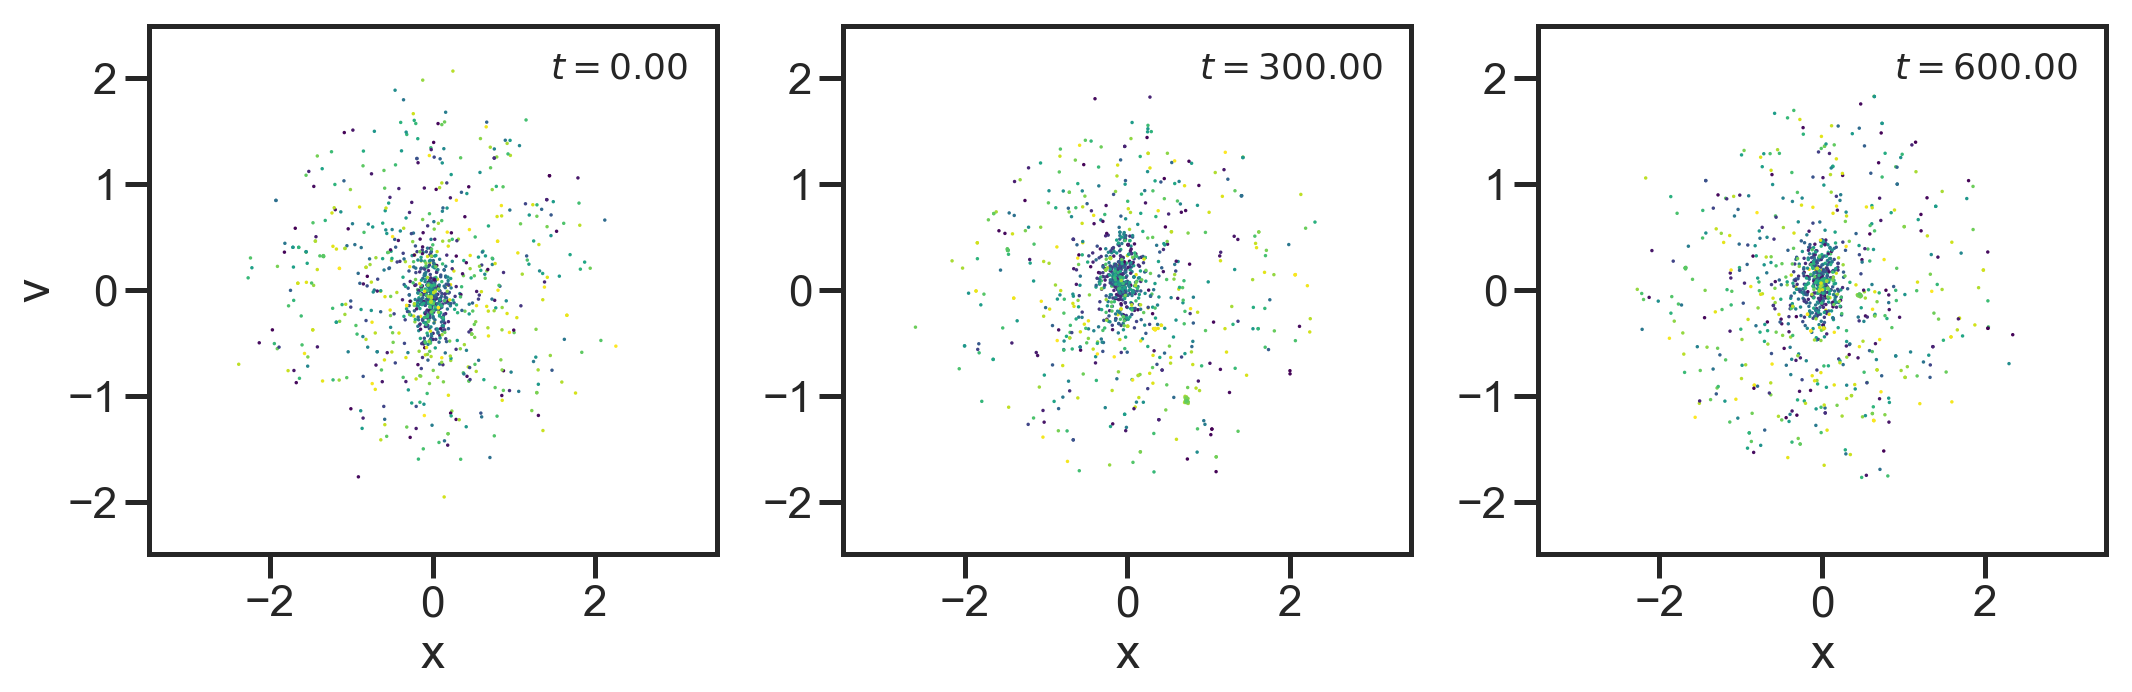

In [108]:
plot_virialized(xtr, vtr, 0, 600, dt)

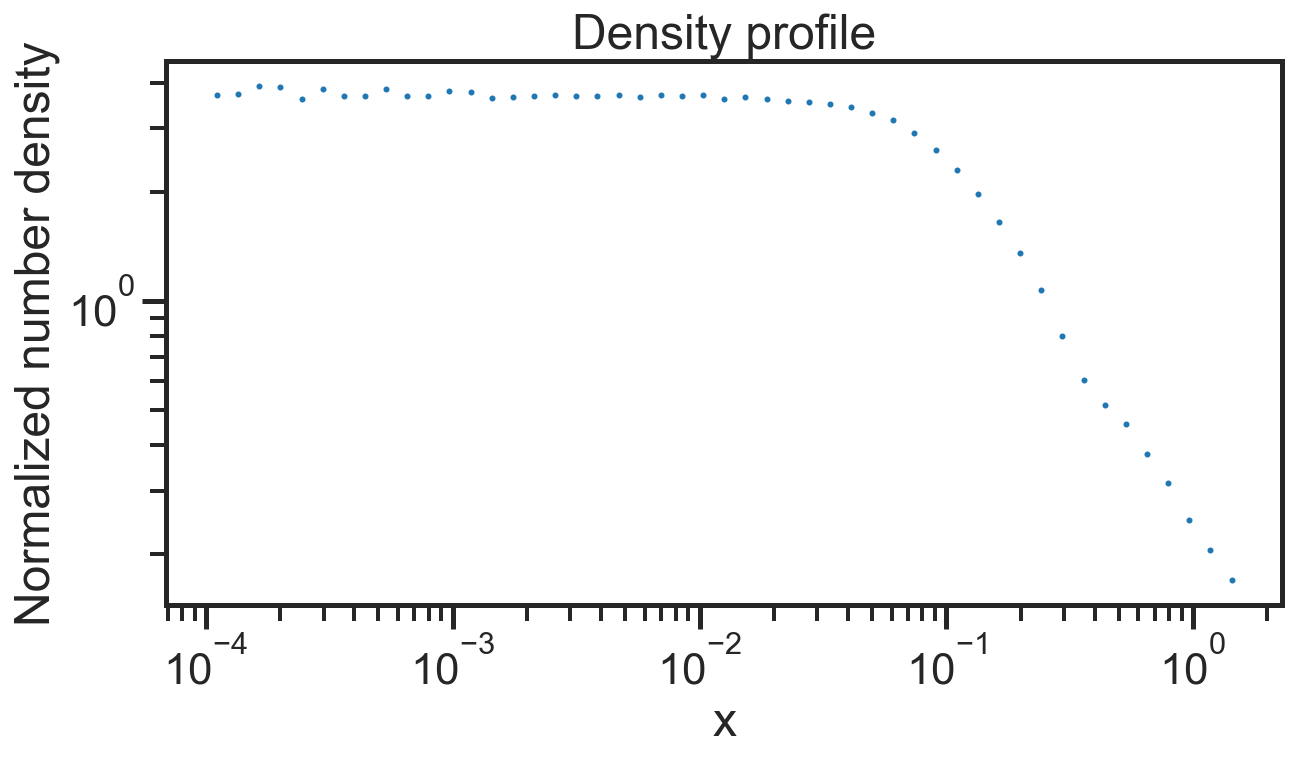

In [254]:
bin_centers_r, densities_r = density_profile_log(xtr, arange(6000, nt))
plot_density_profile(bin_centers_r, densities_r)

### Very small gaussian velocity

In [149]:
vs = 0.1*v0*np.sin(x) + v0*1e-6*np.random.normal(size=N)

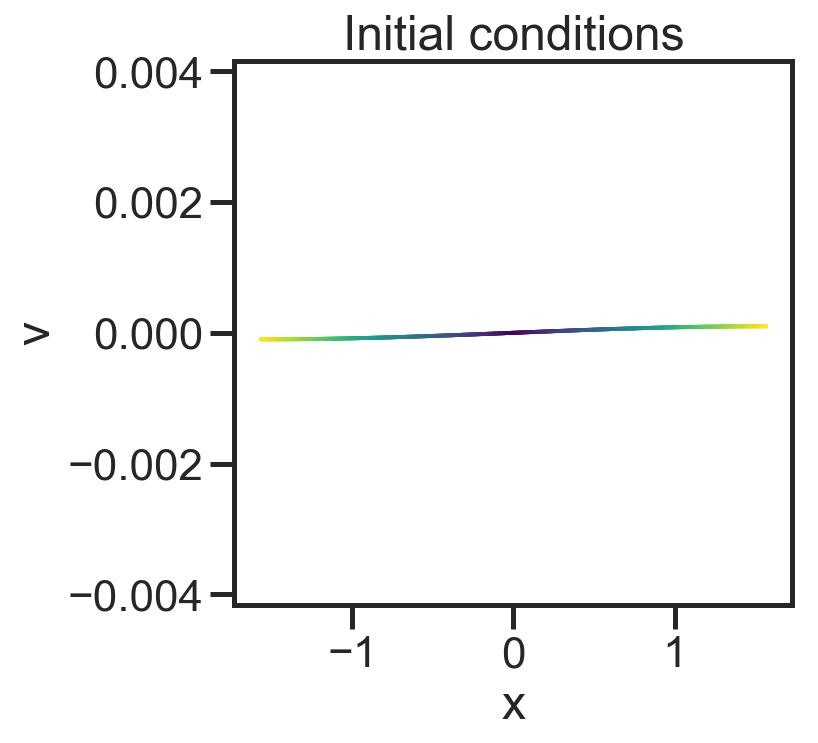

In [150]:
plot_ic(x, vs)

In [151]:
xts, vts, Kts, Pts = sim(x, vs, m, tf, nt)

100%|██████████| 10000/10000 [03:33<00:00, 46.84it/s]


In [144]:
np.save('./data/xts', xts)
np.save('./data/vts', vts)
np.save('./data/Kts', Kts)
np.save('./data/Pts', Pts)

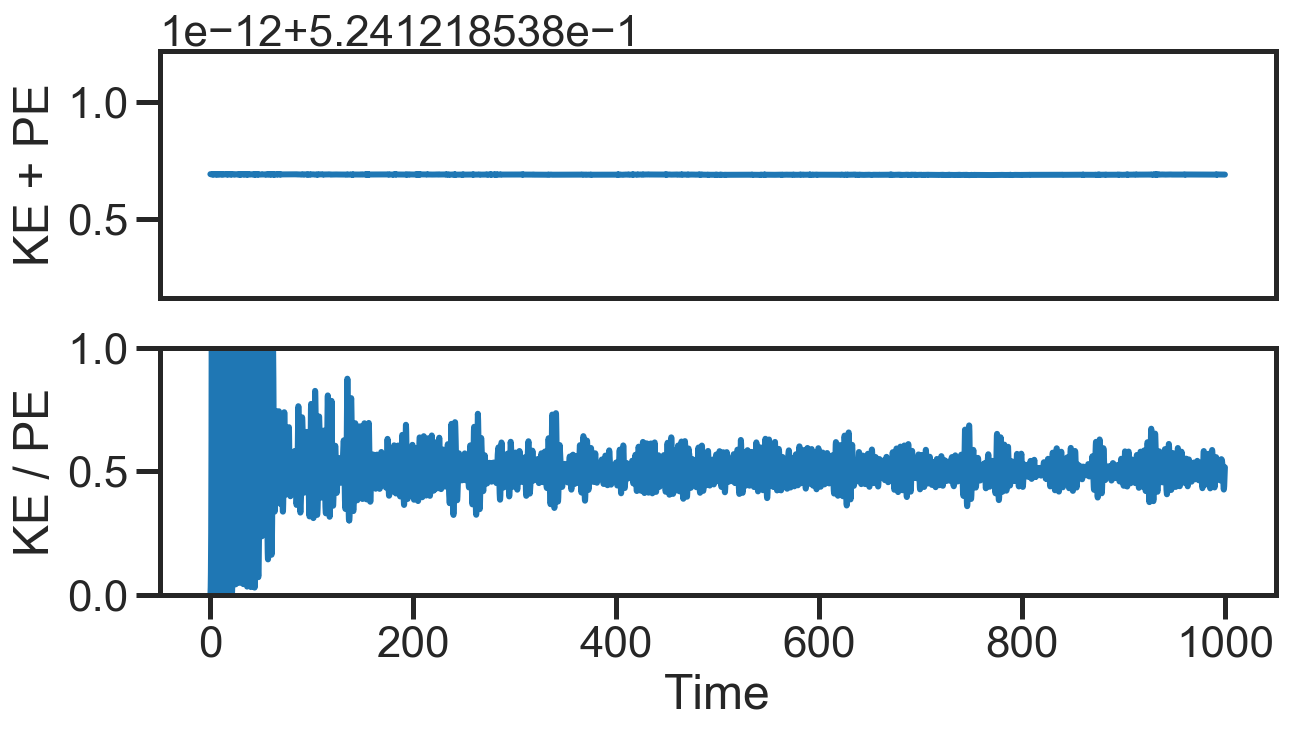

In [152]:
plot_energies(t, Kts, Pts)

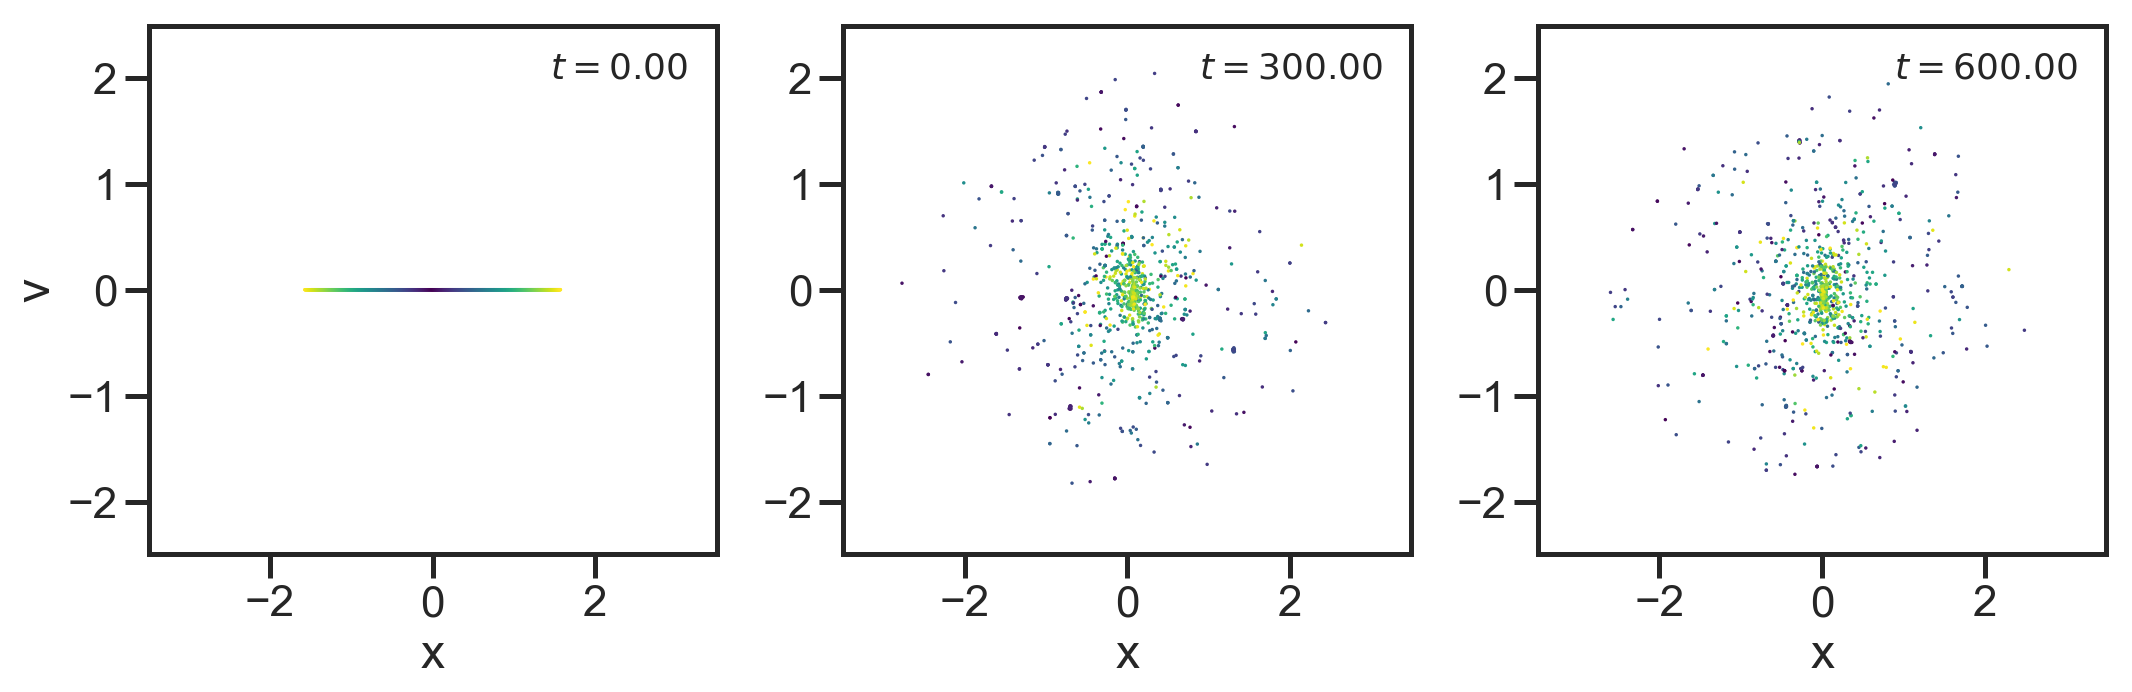

In [153]:
plot_virialized(xts, vts, 0, 600, dt)

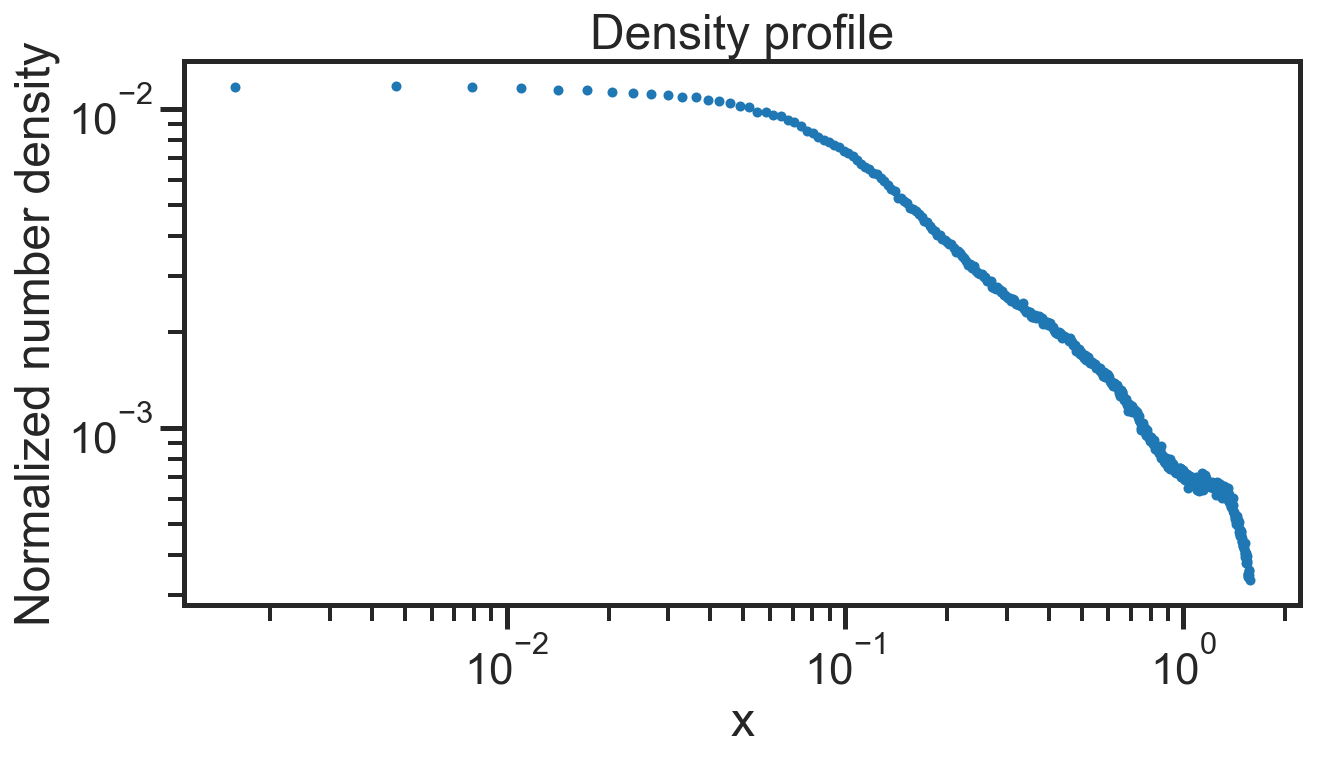

In [154]:
bin_centers_s, densities_s = density_profile(xts, 600)
plot_density_profile(bin_centers_s, densities_s)

Text(0, 0.5, 'Normalized number density')

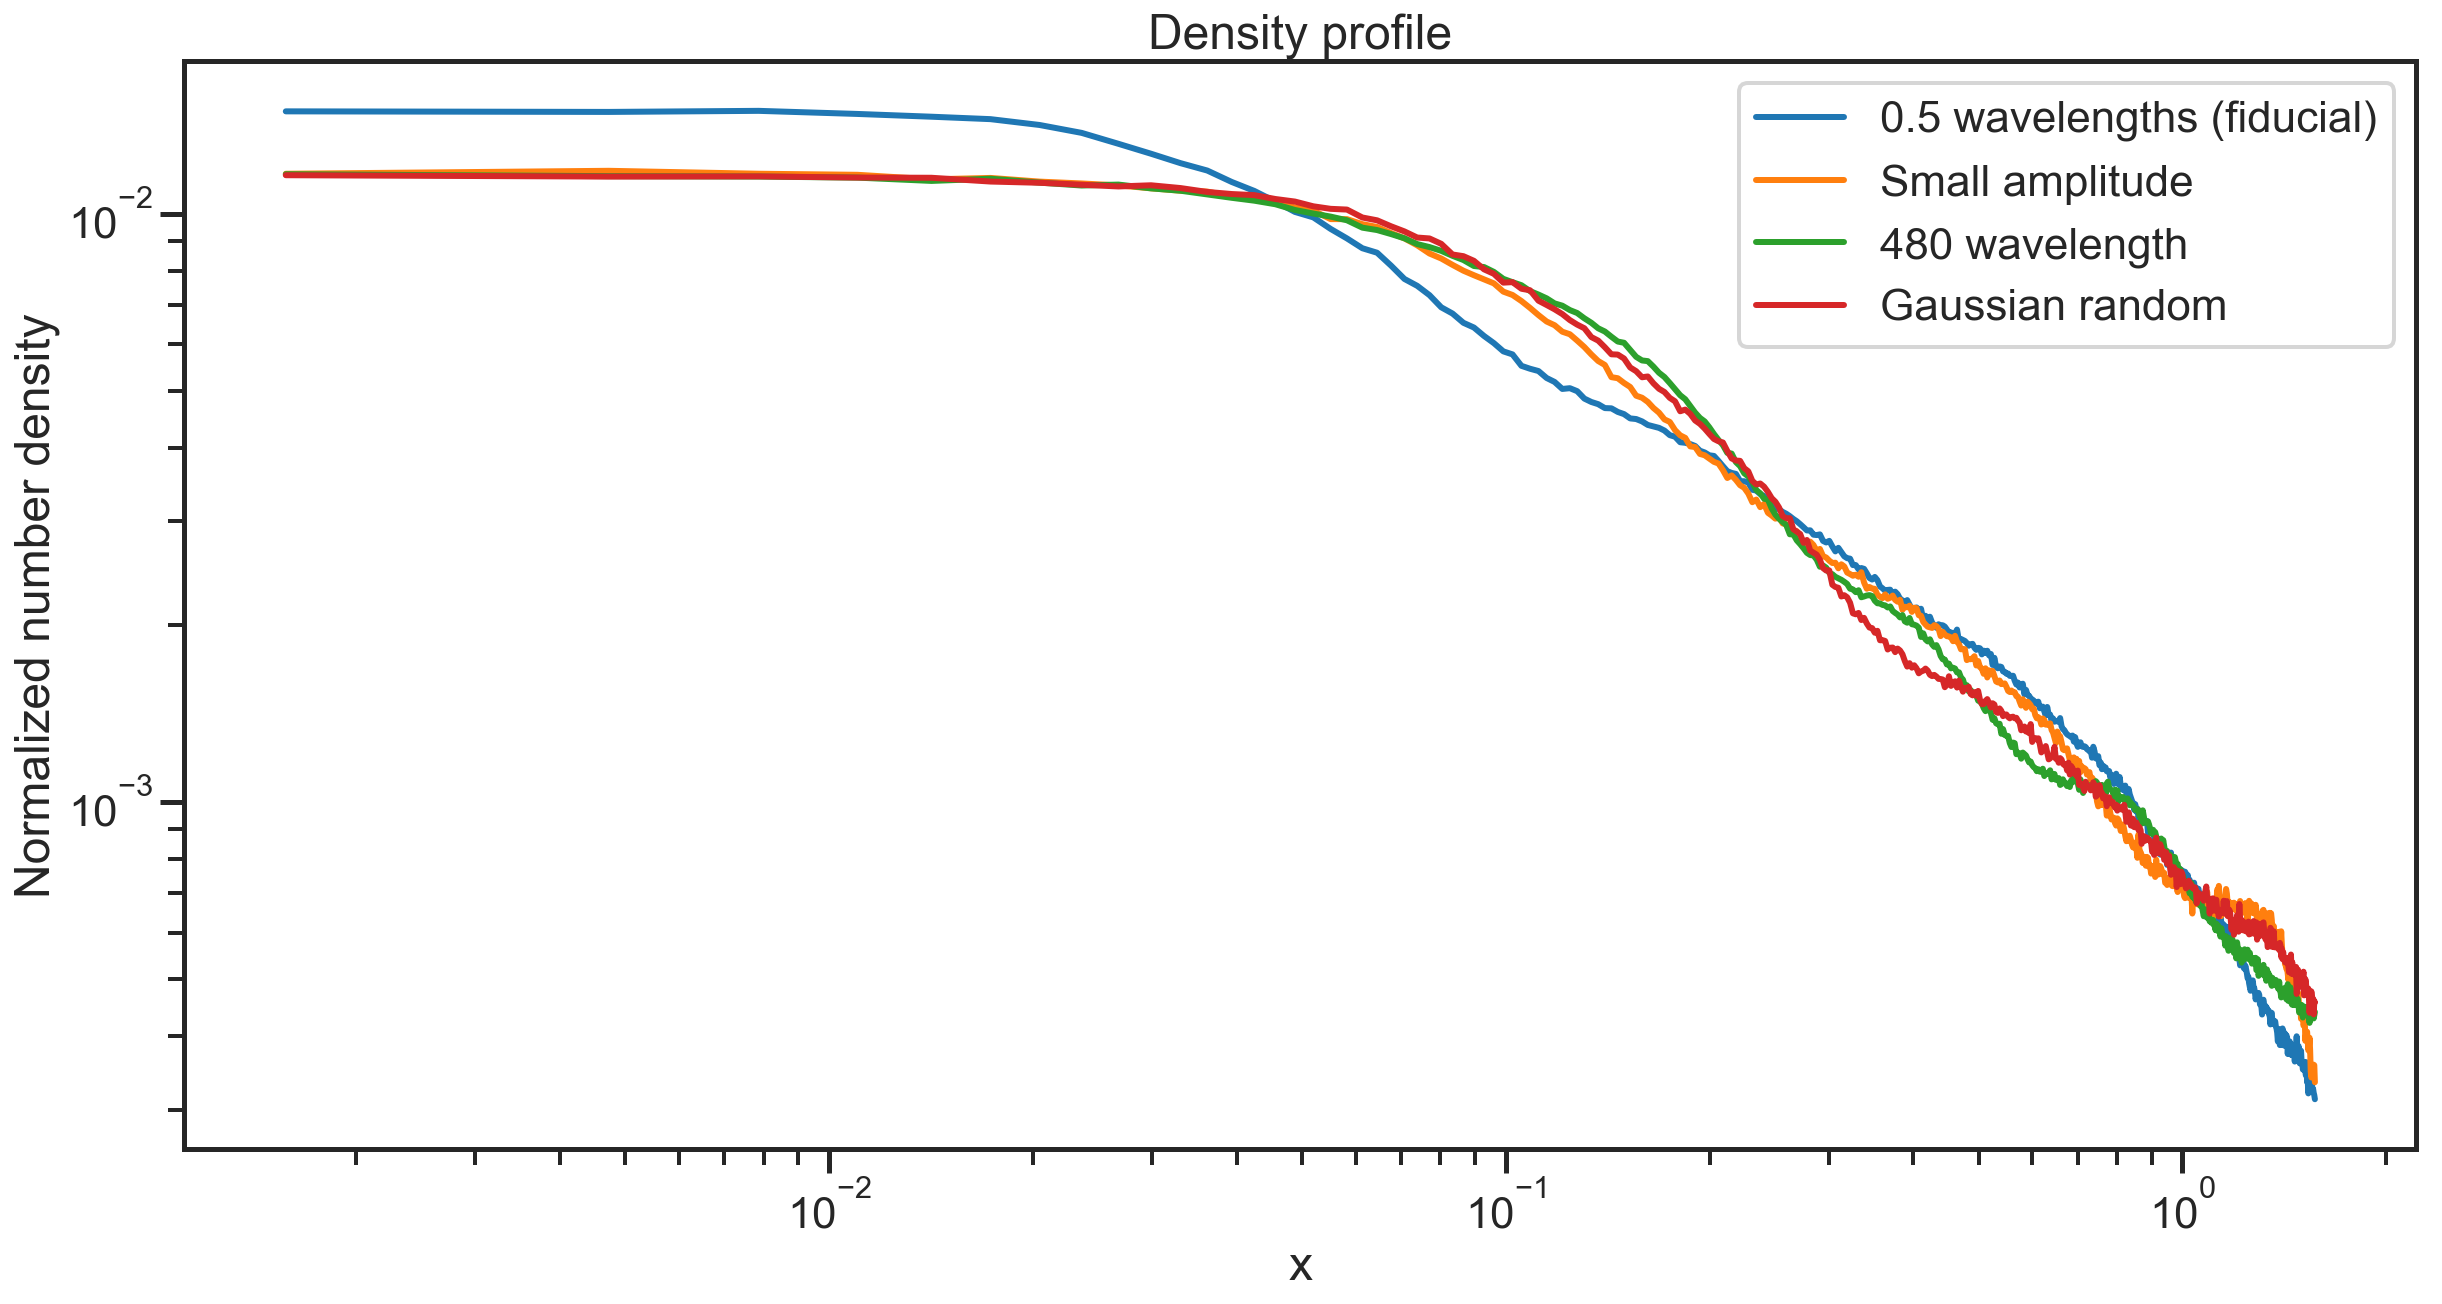

In [155]:
figure(figsize=[20, 10])
loglog(bin_centers, densities, label='0.5 wavelengths (fiducial)')
loglog(bin_centers_s, densities_s, label='Small amplitude')
loglog(bin_centers480, densities480, label='480 wavelength')
loglog(bin_centers_r, densities_r, label='Gaussian random')

legend(loc='best')
title('Density profile')
xlabel('x')
ylabel('Normalized number density')

Text(0, 0.5, 'Normalized number density')

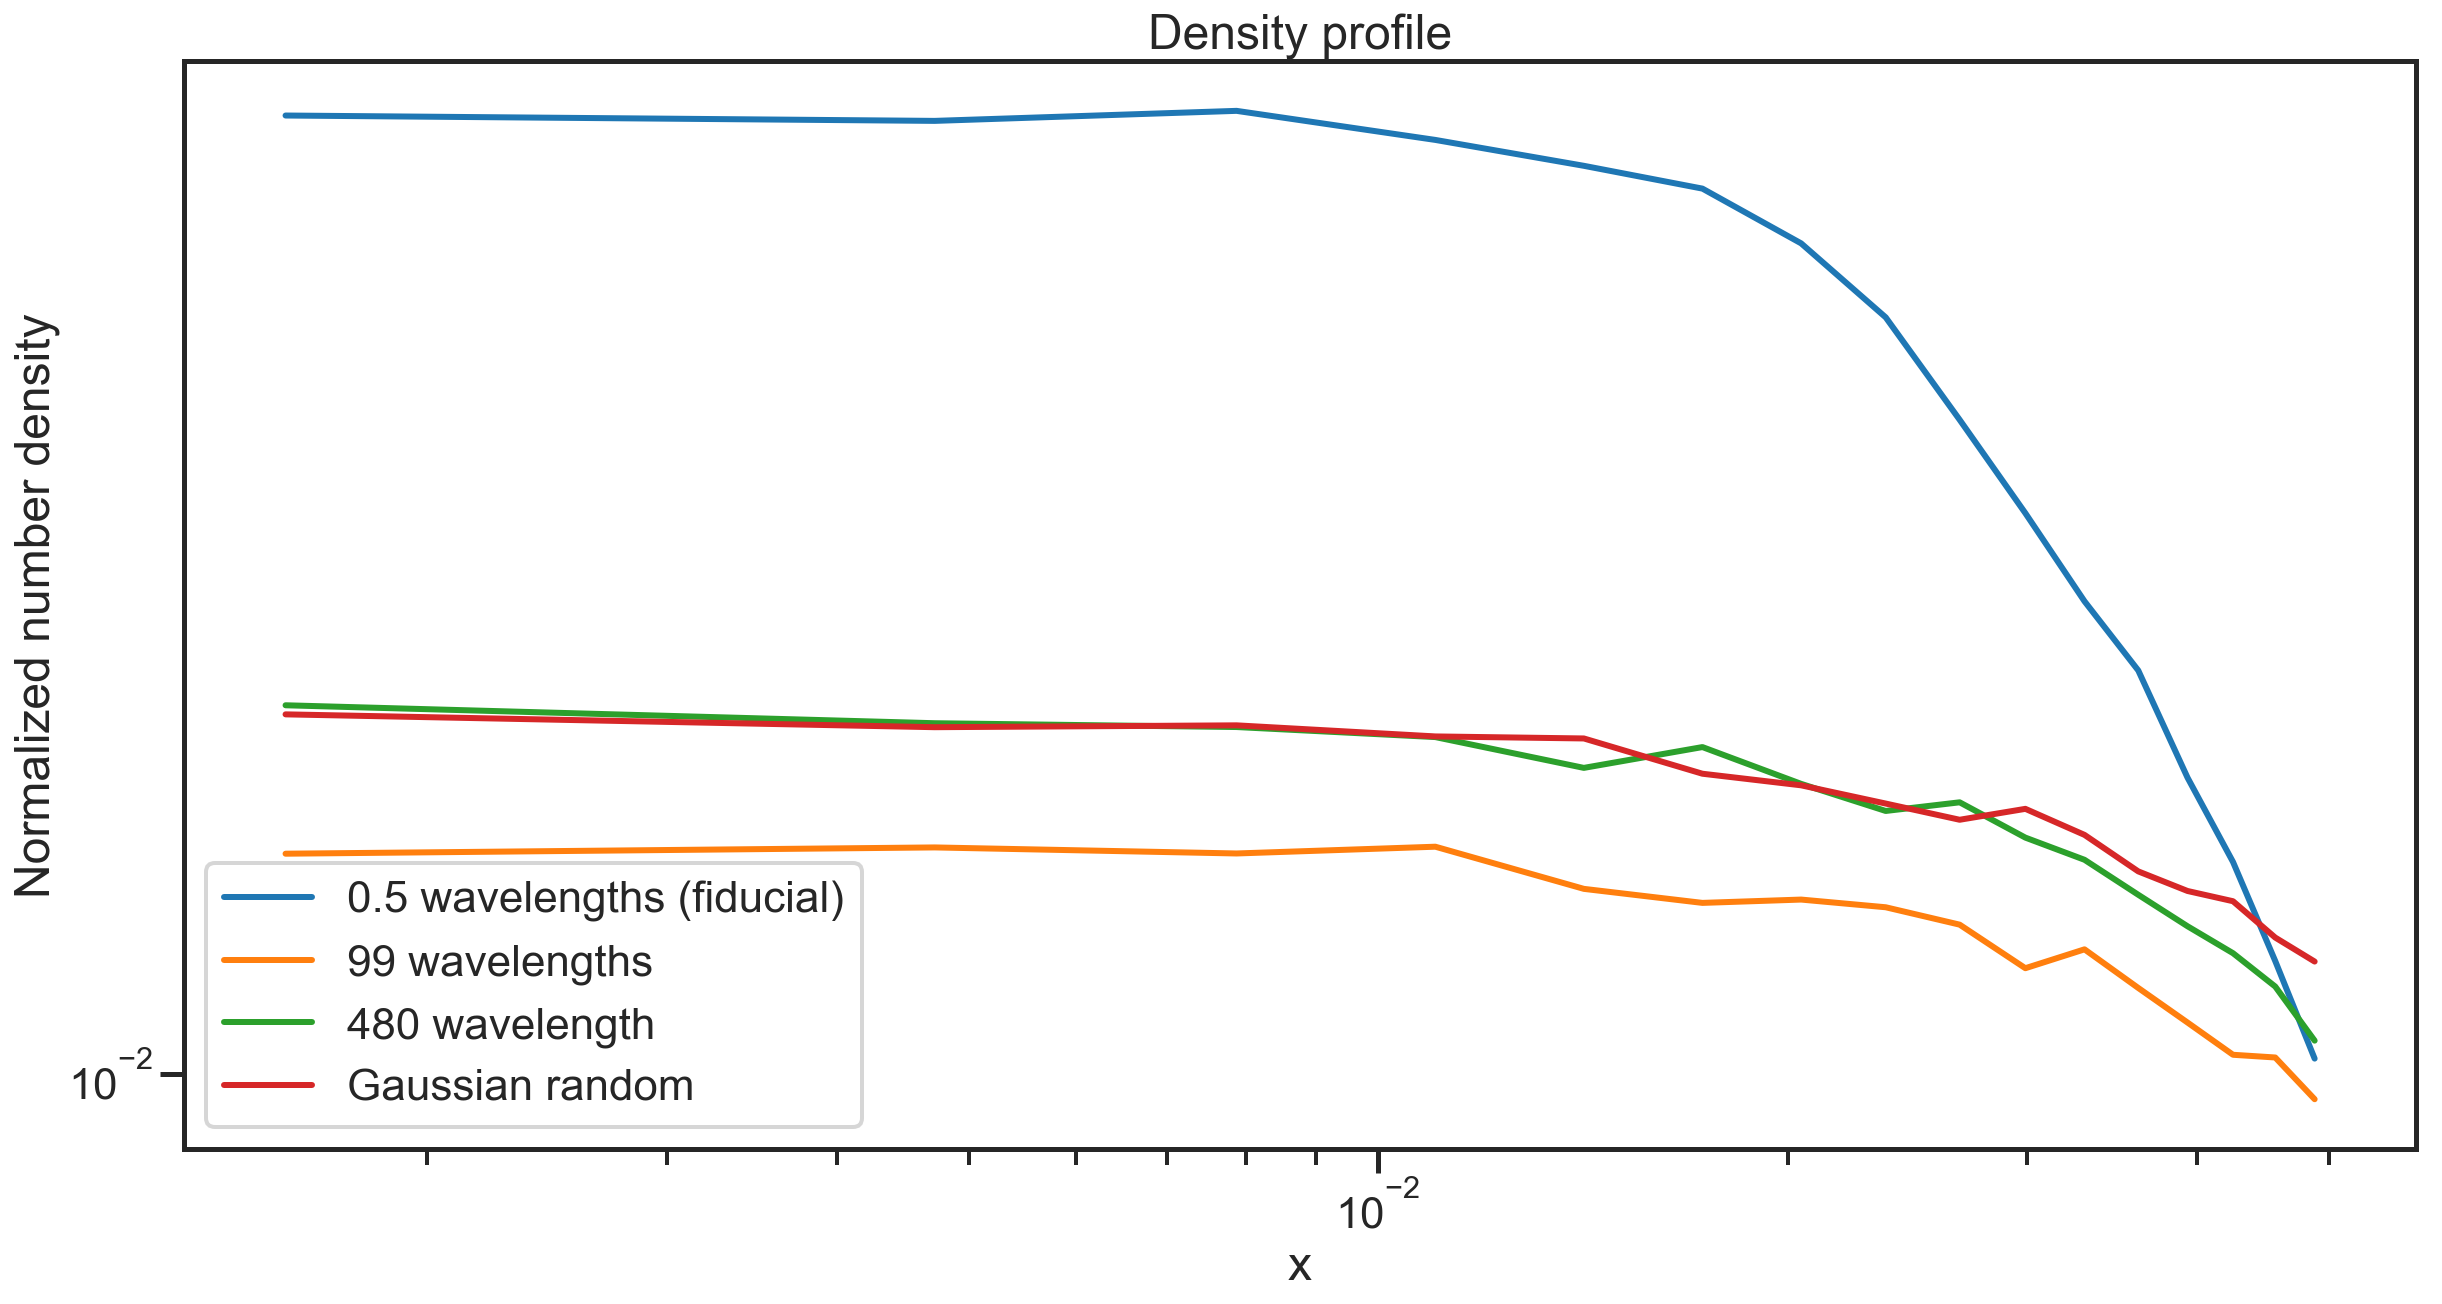

In [106]:
figure(figsize=[20, 10])
s = bin_centers <  .05
loglog(bin_centers[s], densities[s], label='0.5 wavelengths (fiducial)')
loglog(bin_centers99[s], densities99[s], label='99 wavelengths')
loglog(bin_centers480[s], densities480[s], label='480 wavelength')
loglog(bin_centers_r[s], densities_r[s], label='Gaussian random')

legend(loc='best')
title('Density profile')
xlabel('x')
ylabel('Normalized number density')

### 10 * V0

In [159]:
v10v0 = -10*v0*np.sin(x) + v0*1e-6*np.random.normal(size=N)

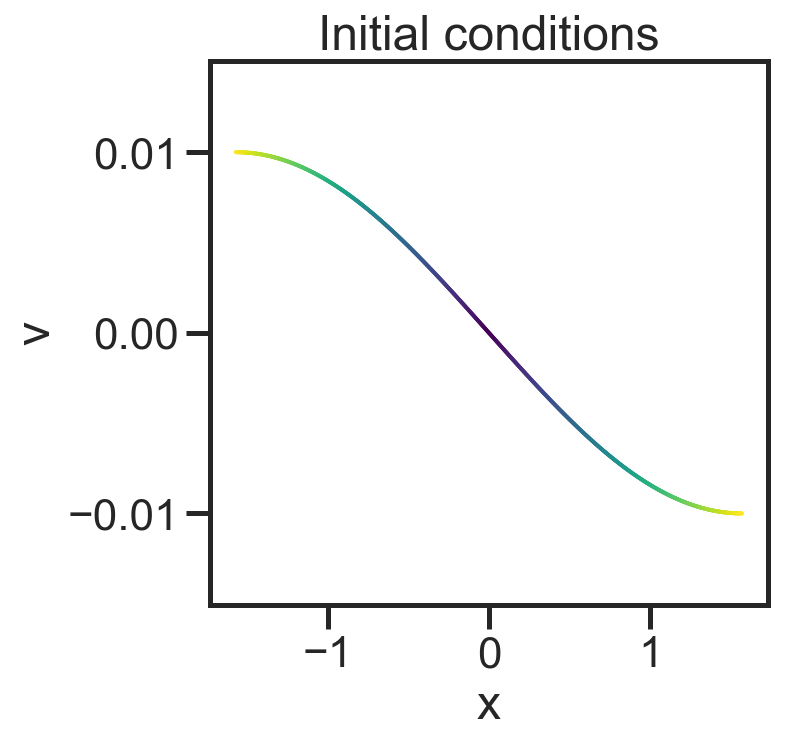

In [160]:
plot_ic(x, v10v0)

In [161]:
xtv10, vtv10, Ktv10, Ptv10 = sim(x, v10v0, m, tf, nt)

100%|██████████| 10000/10000 [03:46<00:00, 44.06it/s]


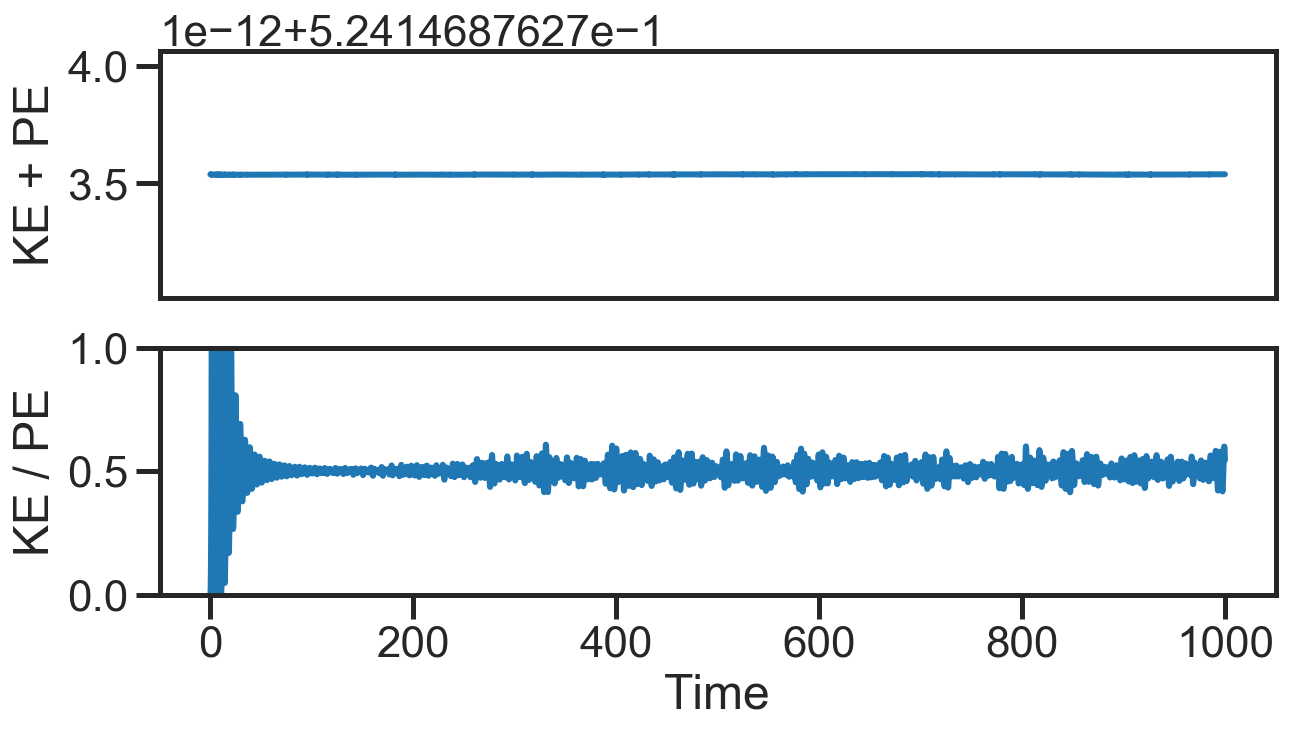

In [162]:
plot_energies(t, Ktv10, Ptv10)

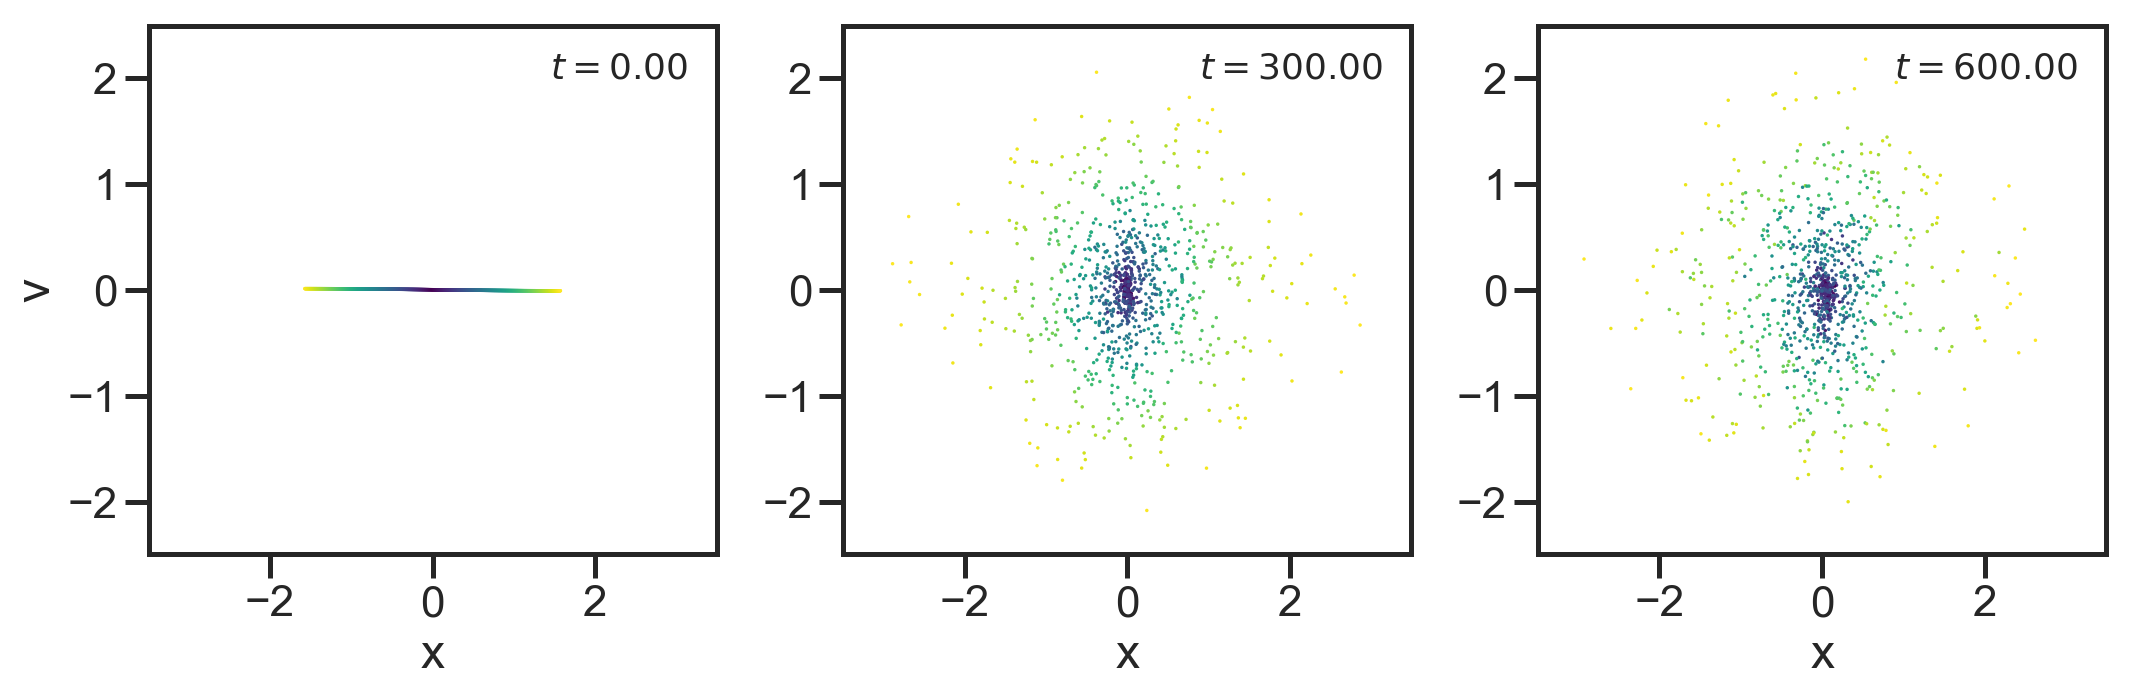

In [163]:
plot_virialized(xtv10, vtv10, 0, 600, dt)

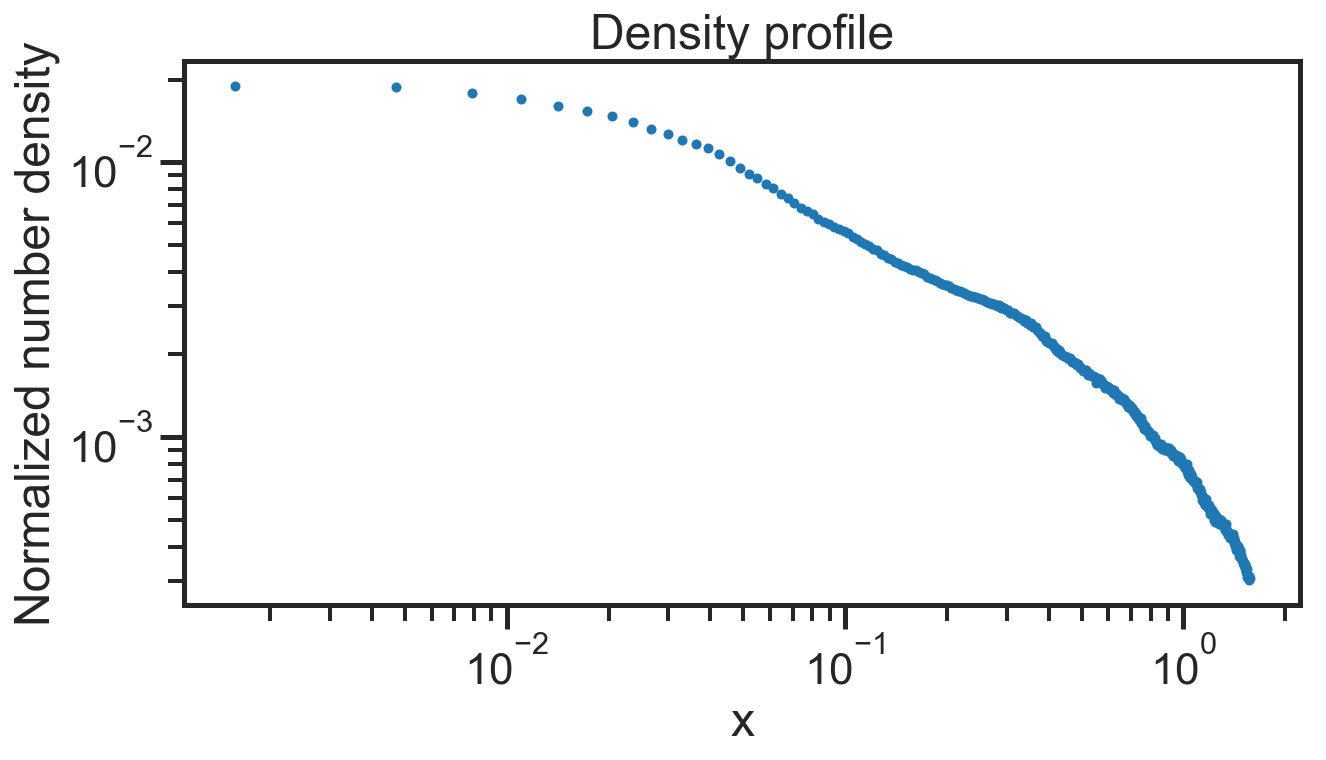

In [173]:
bin_centers_v10, densities_v10 = density_profile(xtv10, 100)
plot_density_profile(bin_centers_v10, densities_v10)

### 100 * V0

In [165]:
v100v0 = -100*v0*np.sin(x) + v0*1e-6*np.random.normal(size=N)

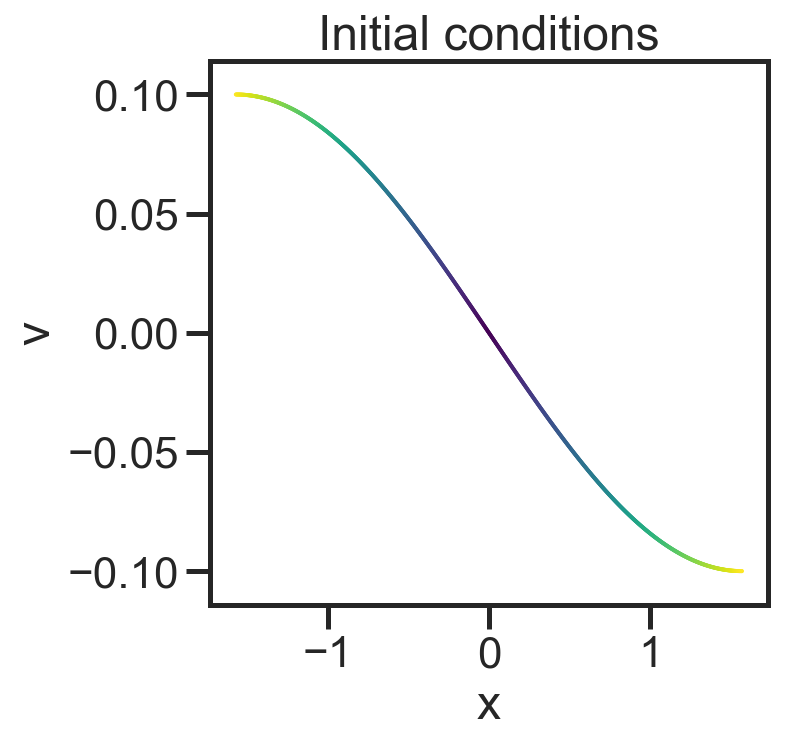

In [166]:
plot_ic(x, v100v0)

In [167]:
xtv100, vtv100, Ktv100, Ptv100 = sim(x, v100v0, m, tf, nt)

100%|██████████| 10000/10000 [03:56<00:00, 42.33it/s]


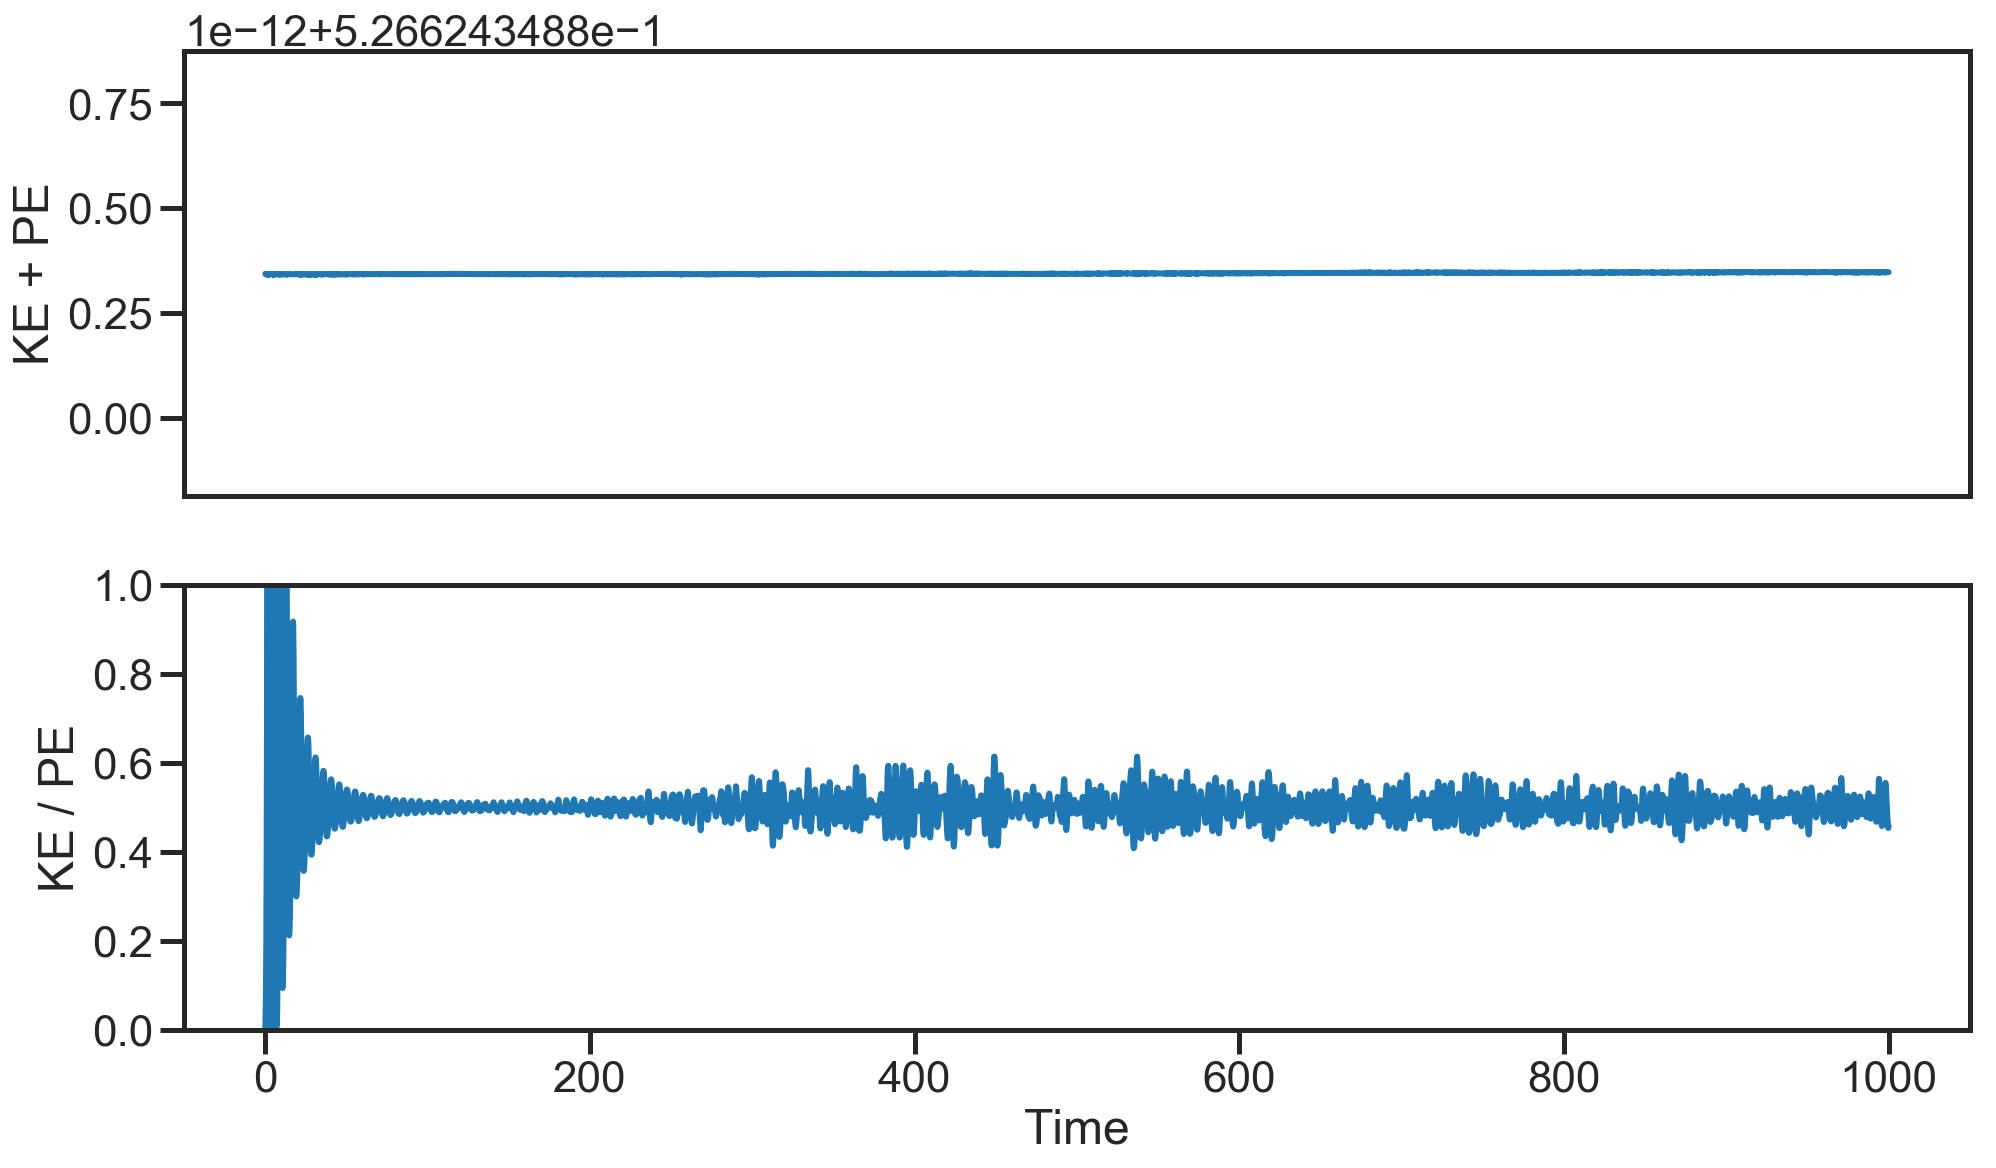

In [243]:
plot_energies(t, Ktv100, Ptv100)

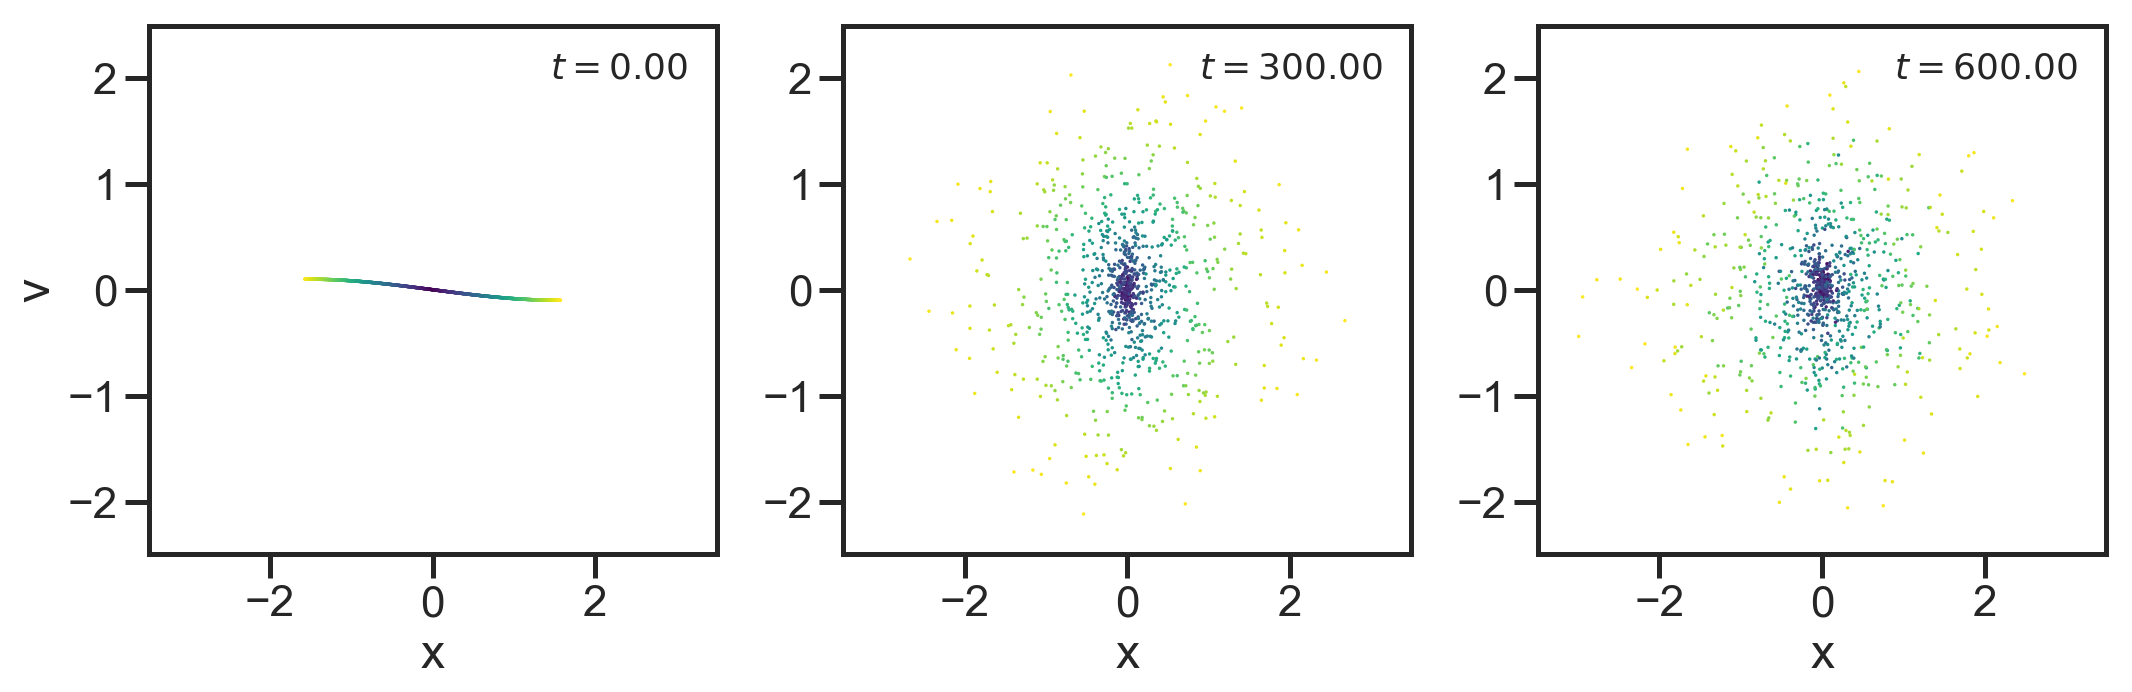

In [169]:
plot_virialized(xtv100, vtv100, 0, 600, dt)

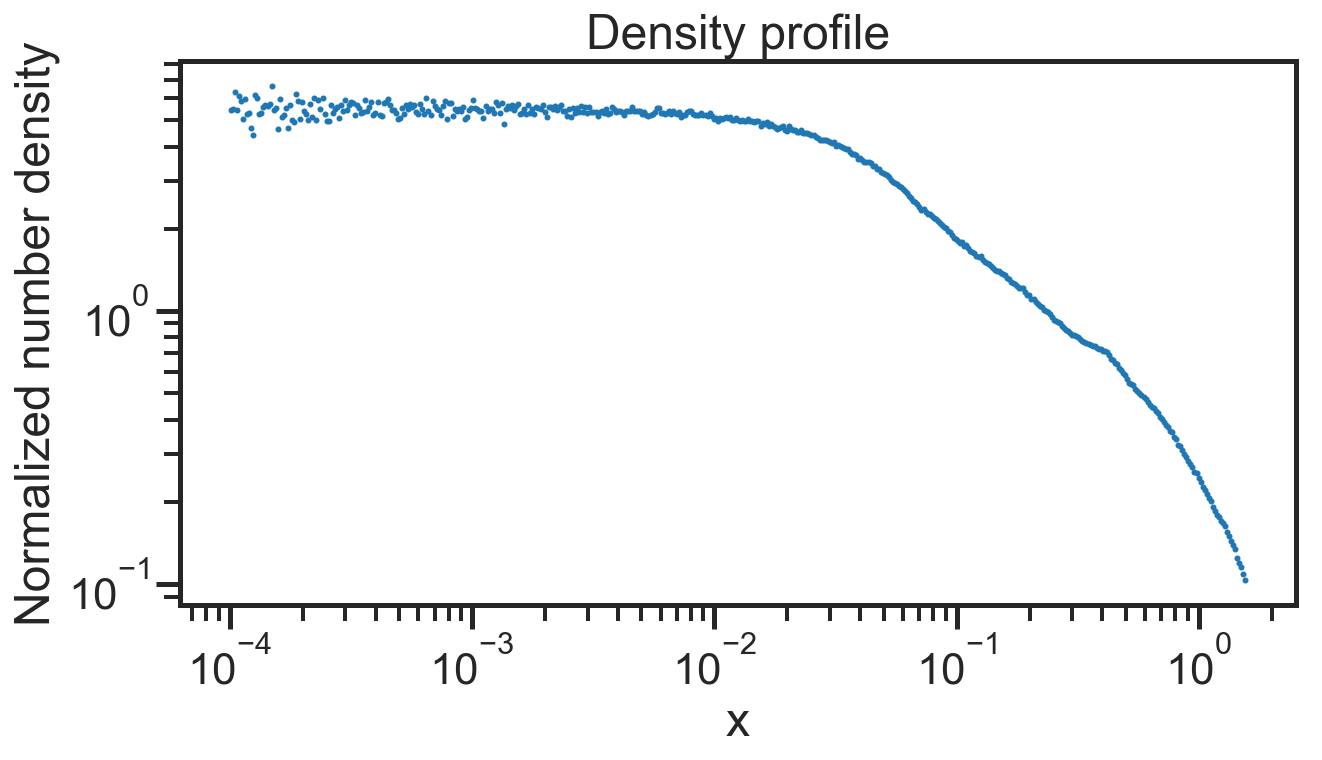

In [242]:
bin_centers_v100, densities_v100 = density_profile_log(xtv100, arange(3000, nt))
plot_density_profile(bin_centers_v100, densities_v100)

Text(0, 0.5, 'Normalized number density')

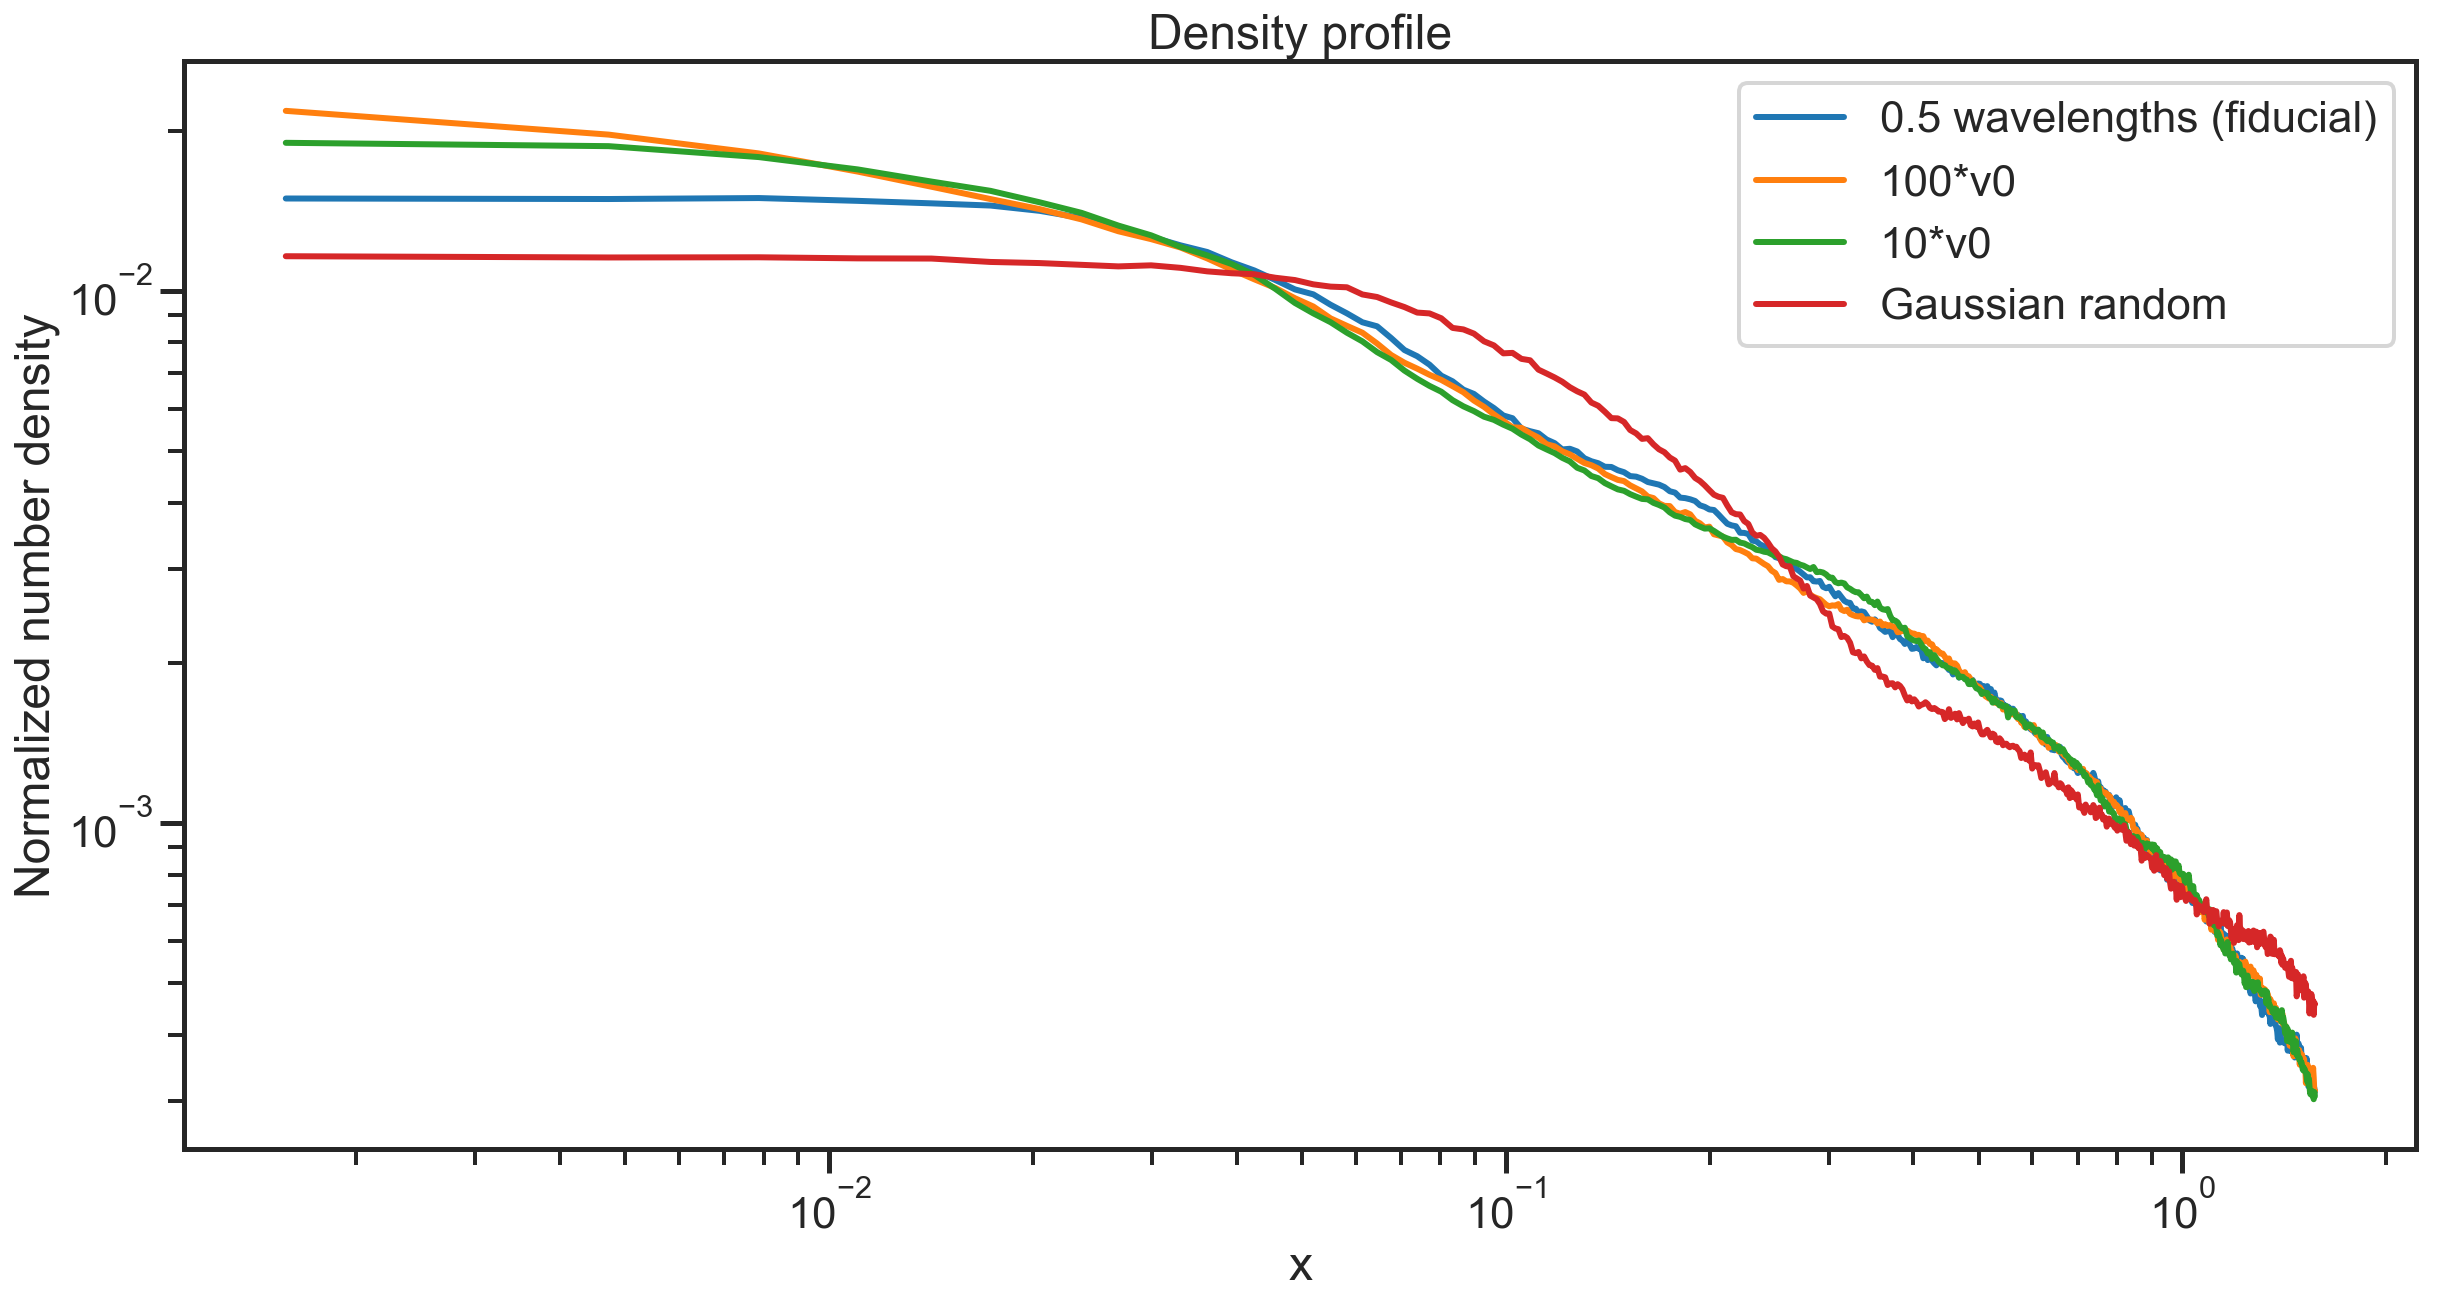

In [176]:
figure(figsize=[20, 10])
s = bin_centers <  .05
loglog(bin_centers, densities, label='0.5 wavelengths (fiducial)')
loglog(bin_centers_v100, densities_v100, label='100*v0')
loglog(bin_centers_v10, densities_v10, label='10*v0')
loglog(bin_centers_r, densities_r, label='Gaussian random')

legend(loc='best')
title('Density profile')
xlabel('x')
ylabel('Normalized number density')